In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

import torch
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
from torch.utils.data import Dataset, DataLoader
from PIL import Image

from tqdm import tqdm_notebook as tqdm

In [2]:
from torch.utils.data import Dataset
from PIL import Image
import os

class HealthyDataset(Dataset):
    def __init__(self, img_dir, transform1=None, transform2=None):
        self.img_dir = img_dir  # Directory where the images are stored
        self.img_names = os.listdir(img_dir)  # List all files in the image directory
        self.transform1 = transform1  # First transformation to apply to the images
        self.transform2 = transform2  # Second transformation to apply to the images

        # Load and optionally transform all images in the directory
        self.imgs = []  # List to store the loaded images
        for img_name in self.img_names:            
            # Open each image
            img = Image.open(os.path.join(img_dir, img_name))

            # Apply the first transformation if it is defined
            if self.transform1 is not None:
                img = self.transform1(img)

            # Add the (transformed) image to the list
            self.imgs.append(img)

    def __getitem__(self, index):
        # Method to get an image by index
        img = self.imgs[index]  # Retrieve the image from the list

        # Apply the second transformation if it is defined
        if self.transform2 is not None:
            img = self.transform2(img)

        # Return the possibly transformed image
        return img

    def __len__(self):
        # Method to get the total number of images
        return len(self.imgs)  # Return the length of the image list

In [3]:
def prepareData(batch_size):
    # Image Preprocessing
    transform1 = transforms.Compose([
        transforms.Resize(64),        # Resize the image to 64x64 pixels
    #     transforms.CenterCrop(64)     # Crop the image to a 64x64 square centered on the middle of the image
    ])

    # Data augmentation and conversion to tensor
    random_transforms = [transforms.RandomRotation(degrees=5)]  # Define random rotation transformation
    transform2 = transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5),  # Randomly flip the images horizontally with a probability of 0.5
    #     transforms.RandomApply(random_transforms, p=0.3),  # Apply the random rotation with a probability of 0.3
        transforms.ToTensor(),  # Convert the images to PyTorch tensors
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize the tensors
    ])

    # Creating the dataset
    train_dataset = HealthyDataset(img_dir='/kaggle/input/healthy-images/Healthy',
                               transform1=transform1,
                               transform2=transform2)

    # DataLoader for the dataset
    train_loader = DataLoader(dataset=train_dataset,
                              batch_size=batch_size,  # Load data in batches
                              shuffle=True,           # Shuffle the data to reduce model overfitting
                              num_workers=4)          # Number of subprocesses to use for data loading

    # Loading a batch of images
    imgs = next(iter(train_loader))  # Get the first batch of images
    imgs = imgs.numpy().transpose(0, 2, 3, 1)  # Convert the images from PyTorch tensor to numpy array and change the shape
    return train_loader, imgs

In [4]:
import torch
import torch.nn as nn


class Discriminator(nn.Module):
    def __init__(self, channels_img = 3, features_d = 64):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            # input: N x channels_img x 64 x 64
            nn.Conv2d(channels_img, features_d, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            # _block(in_channels, out_channels, kernel_size, stride, padding)
            self._block(features_d, features_d * 2, 4, 2, 1),
            self._block(features_d * 2, features_d * 4, 4, 2, 1),
            self._block(features_d * 4, features_d * 8, 4, 2, 1),
            # After all _block img output is 4x4 (Conv2d below makes into 1x1)
            nn.Conv2d(features_d * 8, 1, kernel_size=4, stride=2, padding=0),
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            nn.InstanceNorm2d(out_channels, affine=True),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x):
        return self.disc(x)


class Generator(nn.Module):
    def __init__(self, channels_noise, channels_img = 3, features_g = 64):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            # Input: N x channels_noise x 1 x 1
            self._block(channels_noise, features_g * 16, 4, 1, 0),  # img: 4x4
            self._block(features_g * 16, features_g * 8, 4, 2, 1),  # img: 8x8
            self._block(features_g * 8, features_g * 4, 4, 2, 1),  # img: 16x16
            self._block(features_g * 4, features_g * 2, 4, 2, 1),  # img: 32x32
            nn.ConvTranspose2d(
                features_g * 2, channels_img, kernel_size=4, stride=2, padding=1
            ),
            # Output: N x channels_img x 64 x 64
            nn.Tanh(),
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.net(x)


def initialize_weights(model):
    # Initializes weights according to the DCGAN paper
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)


def test():
    N, in_channels, H, W = 8, 3, 64, 64
    noise_dim = 100
    x = torch.randn((N, in_channels, H, W))
    disc = Discriminator(in_channels, 8)
    if disc(x).shape == (N, 1, 1, 1): 
        print("Discriminator test passed")
    gen = Generator(noise_dim, in_channels, 8)
    z = torch.randn((N, noise_dim, 1, 1))
    if gen(z).shape == (N, in_channels, H, W):
        print("Generator test passed")

test()

Discriminator test passed
Generator test passed


In [5]:
# import torch.nn as nn

# # Generator class
# class Generator(nn.Module):
#     def __init__(self, nz=128, channels=3):
#         super(Generator, self).__init__()
        
#         # Initialize input and output channels
#         self.nz = nz
#         self.channels = channels
        
#         # Define a helper function to create a convolutional layer
#         def convlayer(n_input, n_output, k_size=4, stride=2, padding=0):
#             block = [
#                 nn.ConvTranspose2d(n_input, n_output, kernel_size=k_size, stride=stride, padding=padding, bias=False),
#                 nn.BatchNorm2d(n_output),
#                 nn.ReLU(inplace=True),
#             ]
#             return block

#         # Build the model
#         self.model = nn.Sequential(
#             *convlayer(self.nz, 1024, 4, 1, 0), # First layer: Fully connected layer achieved through convolution.
#             *convlayer(1024, 512, 4, 2, 1),    # Second layer
#             *convlayer(512, 256, 4, 2, 1),     # Third layer
#             *convlayer(256, 128, 4, 2, 1),     # Fourth layer
#             *convlayer(128, 64, 4, 2, 1),      # Fifth layer
#             nn.ConvTranspose2d(64, self.channels, 3, 1, 1), # Final layer to produce output with desired number of channels
#             nn.Tanh() # Tanh activation function for the output
#         )

#     # Forward pass through the generator
#     def forward(self, z):
#         # Reshape input noise vector z to a batch of images
#         z = z.view(-1, self.nz, 1, 1)
#         img = self.model(z)
#         return img

# # Discriminator class
# class Discriminator(nn.Module):
#     def __init__(self, channels=3):
#         super(Discriminator, self).__init__()
        
#         # Initialize input channels
#         self.channels = channels
#         # Define a helper function to create a convolutional layer
#         def convlayer(n_input, n_output, k_size=4, stride=2, padding=0, bn=False):
#             block = [nn.Conv2d(n_input, n_output, kernel_size=k_size, stride=stride, padding=padding, bias=False)]
#             if bn:
#                 block.append(nn.BatchNorm2d(n_output))
#             block.append(nn.LeakyReLU(0.2, inplace=True))
#             return block

#         # Build the model
#         self.model = nn.Sequential(
#             *convlayer(self.channels, 32, 4, 2, 1),  # First layer
#             *convlayer(32, 64, 4, 2, 1),             # Second layer
#             *convlayer(64, 128, 4, 2, 1, bn=True),   # Third layer with batch normalization
#             *convlayer(128, 256, 4, 2, 1, bn=True),  # Fourth layer with batch normalization
#             nn.Conv2d(256, 1, 4, 1, 0, bias=False),  # Final layer: Fully connected layer through convolution
#         )

#     # Forward pass through the discriminator
#     def forward(self, imgs):
#         # Pass the images through the model
#         out = self.model(imgs)
#         # Flatten the output
#         return out.view(-1, 1)

### UTILS (Gradient Penalty,)

In [6]:
import torch
import torch.nn as nn


def gradient_penalty(critic, real, fake, device="cpu"):
    BATCH_SIZE, C, H, W = real.shape
    alpha = torch.rand((BATCH_SIZE, 1, 1, 1)).repeat(1, C, H, W).to(device)
    interpolated_images = real * alpha + fake * (1 - alpha)

    # Calculate critic scores
    mixed_scores = critic(interpolated_images)

    # Take the gradient of the scores with respect to the images
    gradient = torch.autograd.grad(
        inputs=interpolated_images,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True,
    )[0]
    gradient = gradient.view(gradient.shape[0], -1)
    gradient_norm = gradient.norm(2, dim=1)
    gradient_penalty = torch.mean((gradient_norm - 1) ** 2)
    return gradient_penalty


# def save_checkpoint(state, filename="celeba_wgan_gp.pth.tar"):
#     print("=> Saving checkpoint")
#     torch.save(state, filename)


# def load_checkpoint(checkpoint, gen, disc):
#     print("=> Loading checkpoint")
#     gen.load_state_dict(checkpoint['gen'])
#     disc.load_state_dict(checkpoint['disc'])

In [7]:
def show_generated_img(noises, netG, netD, epoch):
    
#     print(f"\n Saving Model")
    print('*'* 10)
        # Save the Generator's state
    torch.save(netG.state_dict(), f'/kaggle/working/generator_ben_{epoch}.pth')  
    # 'netG.state_dict()' retrieves the state (weights and biases) of the generator network (netG).
    # This state is saved to a file named 'generator.pth'.
    # The '.pth' extension is commonly used for PyTorch model files.

    # Save the Discriminator's state
    torch.save(netD.state_dict(), f'/kaggle/working/discriminator_ben_{epoch}.pth')  
    # 'netD.state_dict()' retrieves the state (weights and biases) of the discriminator network (netD).
    # This state is saved to a file named 'discriminator.pth'.
    # The '.pth' extension is commonly used for PyTorch model files.

    # Generate images from the noise vectors using the generator
    gen_images = (netG(noises).to("cpu").clone().detach() + 1) / 2
    # 'netG(gen_z)' passes the noise vectors through the generator to produce a batch of images.
    # '.to("cpu")' moves the generated images to the CPU. This is necessary for converting them into numpy arrays later.
    # '.clone().detach()' creates a copy of the images and detaches them from the current computation graph.
    # '(... + 1) / 2' rescales the pixel values from the range [-1, 1] to [0, 1].
    # This rescaling is necessary because the generator often uses Tanh activation in the output layer, resulting in outputs in the range [-1, 1].
    
    # Convert the images to numpy arrays for visualization
    gen_images = gen_images.numpy().transpose(0, 2, 3, 1)  
    # '.numpy()' converts the tensor of generated images to a numpy array.
    # '.transpose(0, 2, 3, 1)' changes the shape of the array from [batch, channels, height, width] to [batch, height, width, channels].
    # This transposition is required for visualization purposes, as most visualization libraries expect the channel dimension to be last.
    
    # Create a figure for plotting the images
    fig = plt.figure(figsize=(25, 16))  
    # 'figsize=(25, 16)' sets the size of the figure to 25 inches wide and 16 inches tall.
    # This large size helps in better visualization of multiple images.

    # Loop through the generated images
    for ii, img in enumerate(gen_images):
        # Add a subplot for each image in the figure
        ax = fig.add_subplot(4, 8, ii + 1, xticks=[], yticks=[])  
        # '4, 8' means the grid will have 4 rows and 8 columns.
        # 'ii + 1' is the position of the subplot in the grid.
        # 'xticks=[]' and 'yticks=[]' remove the x and y axis tick marks for each subplot.

        # Display the image in the subplot
        plt.imshow(img)  
        # 'plt.imshow' displays the image. 'img' is the current image in the loop.

    # Show the complete figure with all subplots
    plt.show()

In [8]:
import matplotlib.pyplot as plt

def trainData(batch_size, nz, epochs, lr, lambda_gp, num_disc_gen):
    train_loader, imgs = prepareData(batch_size)

    fig = plt.figure(figsize=(25, 16))

    # Loop through the images in the batch, limiting to the first 32 images
    for ii, img in enumerate(imgs[:32]):
        ax = fig.add_subplot(4, 8, ii + 1, xticks=[], yticks=[])
        plt.imshow((img + 1) / 2)

    plt.show()
    # Creating the Generator network
    netG = Generator(nz).to(device)  
    # Initialize the Generator with the specified noise vector size (nz).
    # The .to(device) method moves the model to a GPU if available, otherwise to the CPU.

    # Creating the Discriminator network
    netD = Discriminator().to(device)
    # Initialize the Discriminator.
    # The .to(device) method moves the model to a GPU if available, otherwise to the CPU.

    # Setting up the loss function
    criterion = nn.BCELoss()  
    # Binary Cross Entropy Loss is used, typical for GANs as the discriminator outputs a binary classification (real or fake).

    # Setting up the Optimizer for the Discriminator

    optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))  
    # Use the Adam optimizer for the discriminator.
    # 'lr' is the learning rate, and 'betas' are the hyperparameters for the Adam optimizer.

    # Setting up the Optimizer for the Generator
    optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))  
    # Use the Adam optimizer for the generator, similar to the discriminator.

    # Creating a fixed noise vector for evaluating the Generator's performance
    fixed_noise = torch.randn(32, nz, 1, 1, device=device)  
    # Generate a fixed random noise vector with 25 samples, each of size 'nz'.
    # The noise vector is used to evaluate the generator's output.
    # The .to(device) method moves the noise vector to the same device as the model.
    # Loop over all epochs
    print('*'* 10)
    print(f"\n Starting Training with lr = {lr}, batch_size={batch_size}, epochs={epochs}, nz={nz}, lambda_gp = {lambda_gp}, critic_size = {num_disc_gen}")
    print('*'* 10)
    for epoch in range(epochs):

        # Loop over the batches of images
#         for ii, real_images in tqdm(enumerate(train_loader), total=len(train_loader)):
        for ii, real_images in enumerate(train_loader):
            for _ in range(num_disc_gen):
                # Update Discriminator network:
                # ----------------------------
                netD.zero_grad()  # Reset gradients for the discriminator

                # Move real images to the appropriate device (GPU or CPU)
                real_images = real_images.to(device)

                # Create labels for real images
                batch_size = real_images.size(0)
                labels = torch.full((batch_size, 1), real_label, device=device)

                # Forward pass real images through D
                outputR = netD(real_images)

                # Generate fake images with G
                noise = torch.randn(batch_size, nz, 1, 1, device=device)
                fake = netG(noise)

                # Forward pass fake images through D
                outputF = netD(fake.detach())
                
                # Calculate Gradient Penalty
                gp = gradient_penalty(netD, real_images, fake, device = device)

                # Calculate loss for D and perform backward pass
                errD = (-(torch.mean(outputR) - torch.mean(outputF))+ lambda_gp*gp)
                errD.backward(retain_graph=True)
                optimizerD.step()

            # Update Generator network:
            # -------------------------
            netG.zero_grad()  # Reset gradients for the generator

            # Forward pass fake images through D again
            outputF = netD(fake)

            # Calculate loss for G and perform backward pass
            errG = -torch.mean(outputF)
            errG.backward()
            optimizerG.step()

            # Print statistics
            if (ii+1) % (len(train_loader)//2) == 0:
                print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f'
                      % (epoch + 1, epochs, ii+1, len(train_loader),
                         errD.item(), errG.item()))

        # Show a generated image after each epoch
        if epoch%100 == 0:
            print('Generating images for:', epoch, ' epochs')
            show_generated_img(fixed_noise, netG, netD, epoch)
    
    print('*'* 10)
    print(f"\n Finished Training with lr = {lr}, batch_size={batch_size}, epochs={epochs}, nz={nz}, lambda_gp = {lambda_gp}, critic_size = {num_disc_gen}")
    print('*'* 10)  
    
    print(f"\n Saving Model")
    print('*'* 10)
        # Save the Generator's state
    torch.save(netG.state_dict(), f'/kaggle/working/gen_{lr}_{batch_size}_{epochs}_{nz}_{lambda_gp}_{num_disc_gen}.pth')  
    # 'netG.state_dict()' retrieves the state (weights and biases) of the generator network (netG).
    # This state is saved to a file named 'generator.pth'.
    # The '.pth' extension is commonly used for PyTorch model files.

    # Save the Discriminator's state
    torch.save(netD.state_dict(), f'/kaggle/working/disc_{lr}_{batch_size}_{epochs}_{nz}_{lambda_gp}_{num_disc_gen}.pth')  
    # 'netD.state_dict()' retrieves the state (weights and biases) of the discriminator network (netD).
    # This state is saved to a file named 'discriminator.pth'.
    # The '.pth' extension is commonly used for PyTorch model files.
    
    print('*'* 10)
    print(f"\n Generating Images with lr = {lr}, batch_size={batch_size}, epochs={epochs}, nz={nz}, lambda_gp = {lambda_gp}, critic_size = {num_disc_gen}")
    print('*'* 10)
    
    # Generate random noise vectors
    gen_z = torch.randn(32, nz, 1, 1, device=device)  
    # This creates a batch of 32 random noise vectors, each of size 'nz'.
    # The noise vectors are the input to the generator.
    # The dimensions of the tensor are [batch_size, nz, 1, 1].
    # 'device=device' ensures that the operation is performed on the same device (GPU/CPU) as the model.

    # Generate images from the noise vectors using the generator
    gen_images = (netG(gen_z).to("cpu").clone().detach() + 1) / 2
    # 'netG(gen_z)' passes the noise vectors through the generator to produce a batch of images.
    # '.to("cpu")' moves the generated images to the CPU. This is necessary for converting them into numpy arrays later.
    # '.clone().detach()' creates a copy of the images and detaches them from the current computation graph.
    # '(... + 1) / 2' rescales the pixel values from the range [-1, 1] to [0, 1].
    # This rescaling is necessary because the generator often uses Tanh activation in the output layer, resulting in outputs in the range [-1, 1].

    # Convert the images to numpy arrays for visualization
    gen_images = gen_images.numpy().transpose(0, 2, 3, 1)  
    # '.numpy()' converts the tensor of generated images to a numpy array.
    # '.transpose(0, 2, 3, 1)' changes the shape of the array from [batch, channels, height, width] to [batch, height, width, channels].
    # This transposition is required for visualization purposes, as most visualization libraries expect the channel dimension to be last.
    
    # Create a figure for plotting the images
    fig = plt.figure(figsize=(25, 16))  
    # 'figsize=(25, 16)' sets the size of the figure to 25 inches wide and 16 inches tall.
    # This large size helps in better visualization of multiple images.

    # Loop through the generated images
    for ii, img in enumerate(gen_images):
        # Add a subplot for each image in the figure
        ax = fig.add_subplot(4, 8, ii + 1, xticks=[], yticks=[])  
        # '4, 8' means the grid will have 4 rows and 8 columns.
        # 'ii + 1' is the position of the subplot in the grid.
        # 'xticks=[]' and 'yticks=[]' remove the x and y axis tick marks for each subplot.

        # Display the image in the subplot
        plt.imshow(img)  
        # 'plt.imshow' displays the image. 'img' is the current image in the loop.

    # Show the complete figure with all subplots
    plt.show()
    
    
    print('*'* 10)
    print(f"\n Saving Images with lr = {lr}, batch_size={batch_size}, epochs={epochs}, nz={nz}, lambda_gp = {lambda_gp}, critic_size = {num_disc_gen}")
    print('*'* 10)
    
    if not os.path.exists(f'/kaggle/working/images_{lr}_{batch_size}_{epochs}_{nz}_{lambda_gp}_{num_disc_gen}'):
        os.mkdir(f'/kaggle/working/images_{lr}_{batch_size}_{epochs}_{nz}_{lambda_gp}_{num_disc_gen}')  
        # '../output_images' is the directory where generated images will be saved.
        # 'os.mkdir' creates the directory if it does not already exist.

    # Define batch size for image generation and total number of images to generate
    im_batch_size = 1  # Number of images to generate in each batch.
    n_images = 100    # Total number of images to generate.

    # Generate and save images in batches
    for i_batch in range(0, n_images, im_batch_size):
        # Generate a batch of noise vectors
        gen_z = torch.randn(im_batch_size, nz, 1, 1, device=device)  
        # 'torch.randn' generates a tensor of random values from a normal distribution.
        # The tensor has dimensions [im_batch_size, nz, 1, 1].

        # Generate images from the noise vectors
        gen_images = (netG(gen_z) + 1) / 2  
        # 'netG(gen_z)' generates a batch of images.
        # '(... + 1) / 2' rescales the images from [-1, 1] to [0, 1].

        # Prepare images for saving
        images = gen_images.to("cpu").clone().detach()  
        # Move images to CPU and detach from computation graph.
        images = images.numpy().transpose(0, 2, 3, 1)  
        # Convert to numpy array and change shape from [batch, channels, height, width] to [batch, height, width, channels].

#         Save each image in the batch to disk
        for i_image in range(gen_images.size(0)):
            # Construct the file path
            image_path = os.path.join(f'/kaggle/working/images_{lr}_{batch_size}_{epochs}_{nz}_{lambda_gp}_{num_disc_gen}', f'image_{i_batch+i_image:05d}.png')  
            # 'f'image_{i_batch+i_image:05d}.png'' formats the filename with leading zeros.

            # Save the image
            save_image(gen_images[i_image, :, :, :], image_path)  
            # 'save_image' saves the individual image to the specified path.

## Hyperparameter Tuning

In [9]:
nz_range = [30]  # Adjust the range and number of points as needed
epochs_range = [1000]  # Adjust the range and number of points as needed
lr_sizes = [0.0001]  # Adjust the range and number of points as needed
batch_size_range = [16]  # You might want to keep batch size as specific values
# Possible values for batch_size, epochs, and nz
batch_sizes = batch_size_range  # Add more values as needed
epochs_values = epochs_range  # Add more values as needed
nz_values = nz_range  # Add more values as needed
lambda_gp_sizes = [10]
num_disc_gen_sizes = [2]


Training with lr = 0.0001, batch_size=16, epochs=1000, nz=30, lambda_gp = 10, critic_size = 2


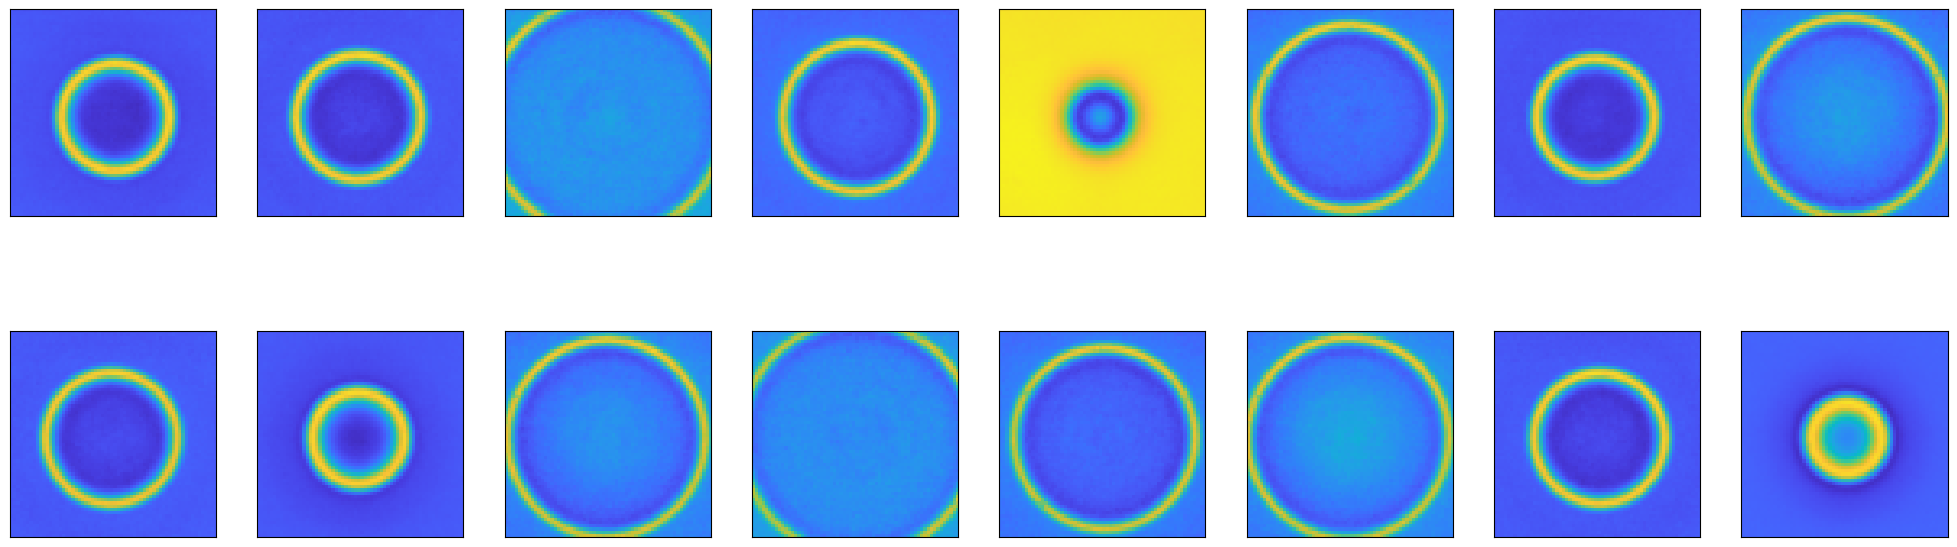

**********

 Starting Training with lr = 0.0001, batch_size=16, epochs=1000, nz=30, lambda_gp = 10, critic_size = 2
**********
[1/1000][11/23] Loss_D: -12.3117 Loss_G: 8.2937
[1/1000][22/23] Loss_D: -38.8319 Loss_G: 21.2249
Generating images for: 0  epochs
**********


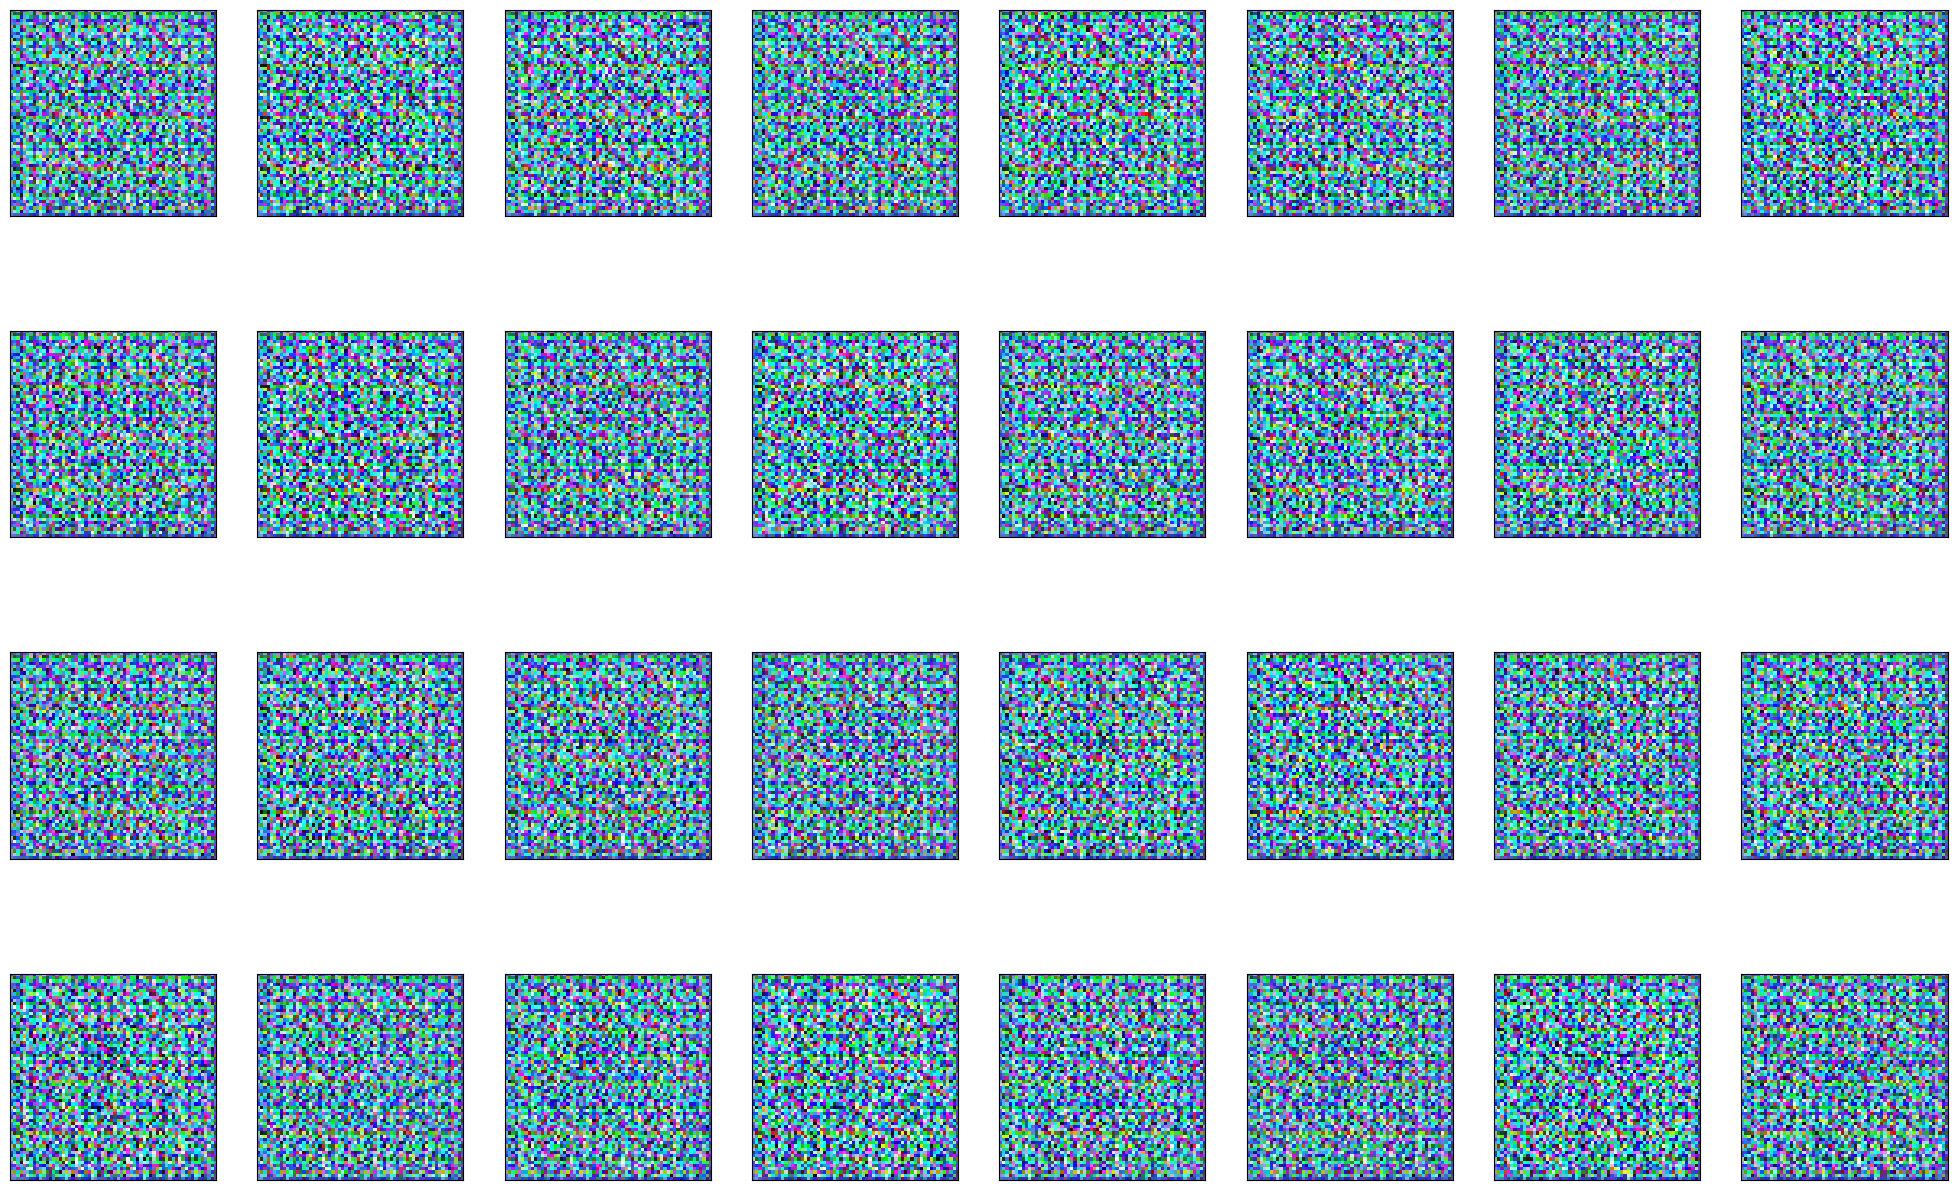

[2/1000][11/23] Loss_D: -53.2790 Loss_G: 31.0722
[2/1000][22/23] Loss_D: -64.1830 Loss_G: 40.3636
[3/1000][11/23] Loss_D: -63.6023 Loss_G: 47.8553
[3/1000][22/23] Loss_D: -68.1789 Loss_G: 47.4141
[4/1000][11/23] Loss_D: -72.9121 Loss_G: 50.0496
[4/1000][22/23] Loss_D: -72.9712 Loss_G: 50.6131
[5/1000][11/23] Loss_D: -74.7997 Loss_G: 52.4904
[5/1000][22/23] Loss_D: -66.7958 Loss_G: 47.8158
[6/1000][11/23] Loss_D: -61.6428 Loss_G: 47.6677
[6/1000][22/23] Loss_D: -75.1014 Loss_G: 55.1527
[7/1000][11/23] Loss_D: -75.8899 Loss_G: 54.4047
[7/1000][22/23] Loss_D: -54.9456 Loss_G: 50.0296
[8/1000][11/23] Loss_D: -67.4326 Loss_G: 60.4784
[8/1000][22/23] Loss_D: -67.1185 Loss_G: 53.9801
[9/1000][11/23] Loss_D: -72.6997 Loss_G: 48.8119
[9/1000][22/23] Loss_D: -65.7266 Loss_G: 51.0662
[10/1000][11/23] Loss_D: -74.5657 Loss_G: 57.5215
[10/1000][22/23] Loss_D: -63.7603 Loss_G: 55.2364
[11/1000][11/23] Loss_D: -69.2079 Loss_G: 46.1865
[11/1000][22/23] Loss_D: -58.9250 Loss_G: 57.6779
[12/1000][11/23]

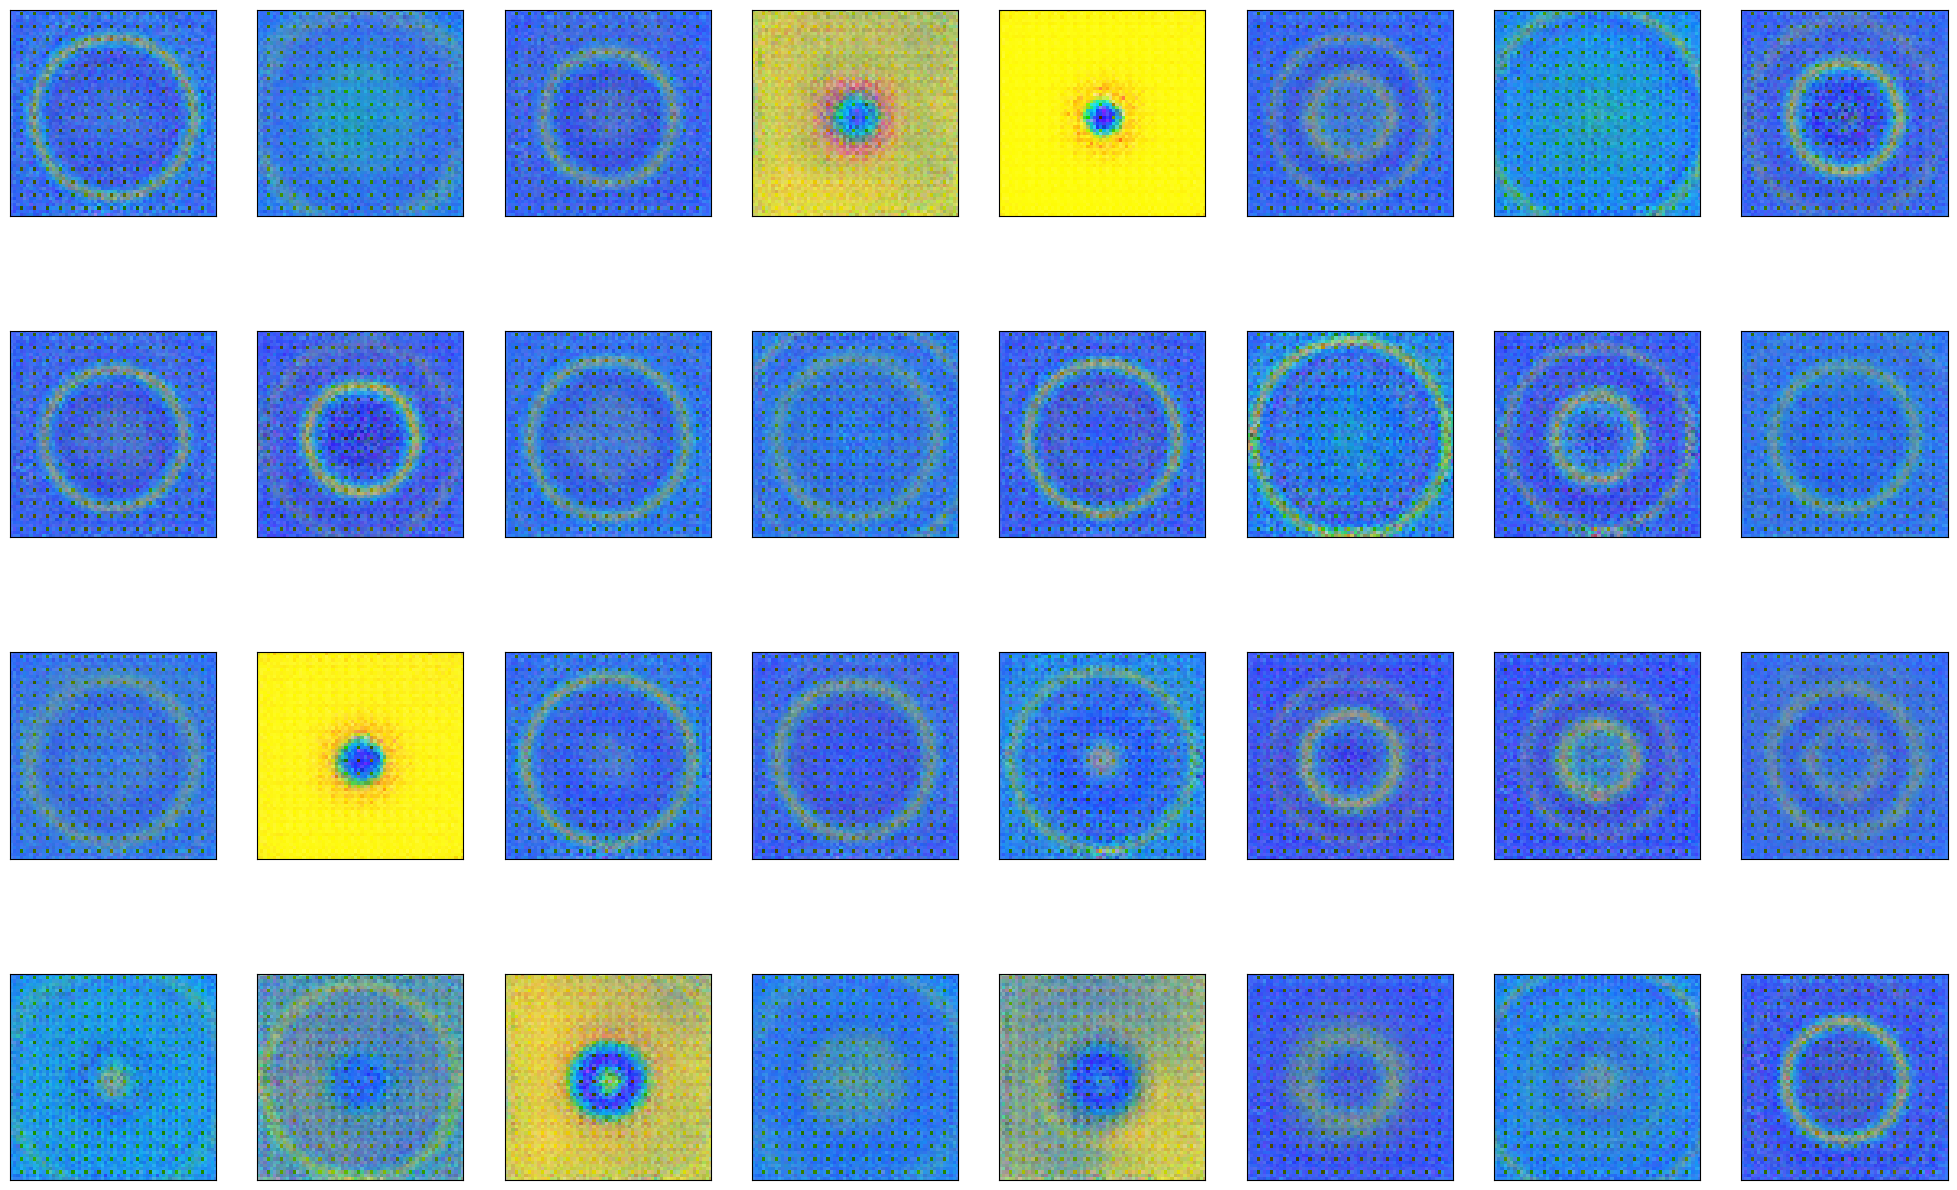

[102/1000][11/23] Loss_D: -86.3832 Loss_G: 62.1616
[102/1000][22/23] Loss_D: -70.4405 Loss_G: 60.5140
[103/1000][11/23] Loss_D: -85.1264 Loss_G: 60.9776
[103/1000][22/23] Loss_D: -70.1356 Loss_G: 53.0120
[104/1000][11/23] Loss_D: -80.8223 Loss_G: 64.1948
[104/1000][22/23] Loss_D: -62.0725 Loss_G: 58.4733
[105/1000][11/23] Loss_D: -78.7202 Loss_G: 72.3596
[105/1000][22/23] Loss_D: -73.7340 Loss_G: 52.4324
[106/1000][11/23] Loss_D: -89.2215 Loss_G: 63.2918
[106/1000][22/23] Loss_D: -75.4740 Loss_G: 64.7272
[107/1000][11/23] Loss_D: -76.6979 Loss_G: 55.8587
[107/1000][22/23] Loss_D: -74.5905 Loss_G: 65.5916
[108/1000][11/23] Loss_D: -77.9886 Loss_G: 60.9747
[108/1000][22/23] Loss_D: -81.1538 Loss_G: 61.8712
[109/1000][11/23] Loss_D: -79.2763 Loss_G: 64.1179
[109/1000][22/23] Loss_D: -68.3260 Loss_G: 57.6946
[110/1000][11/23] Loss_D: -82.3796 Loss_G: 58.6265
[110/1000][22/23] Loss_D: -76.2309 Loss_G: 59.2823
[111/1000][11/23] Loss_D: -84.8356 Loss_G: 63.7245
[111/1000][22/23] Loss_D: -80.4

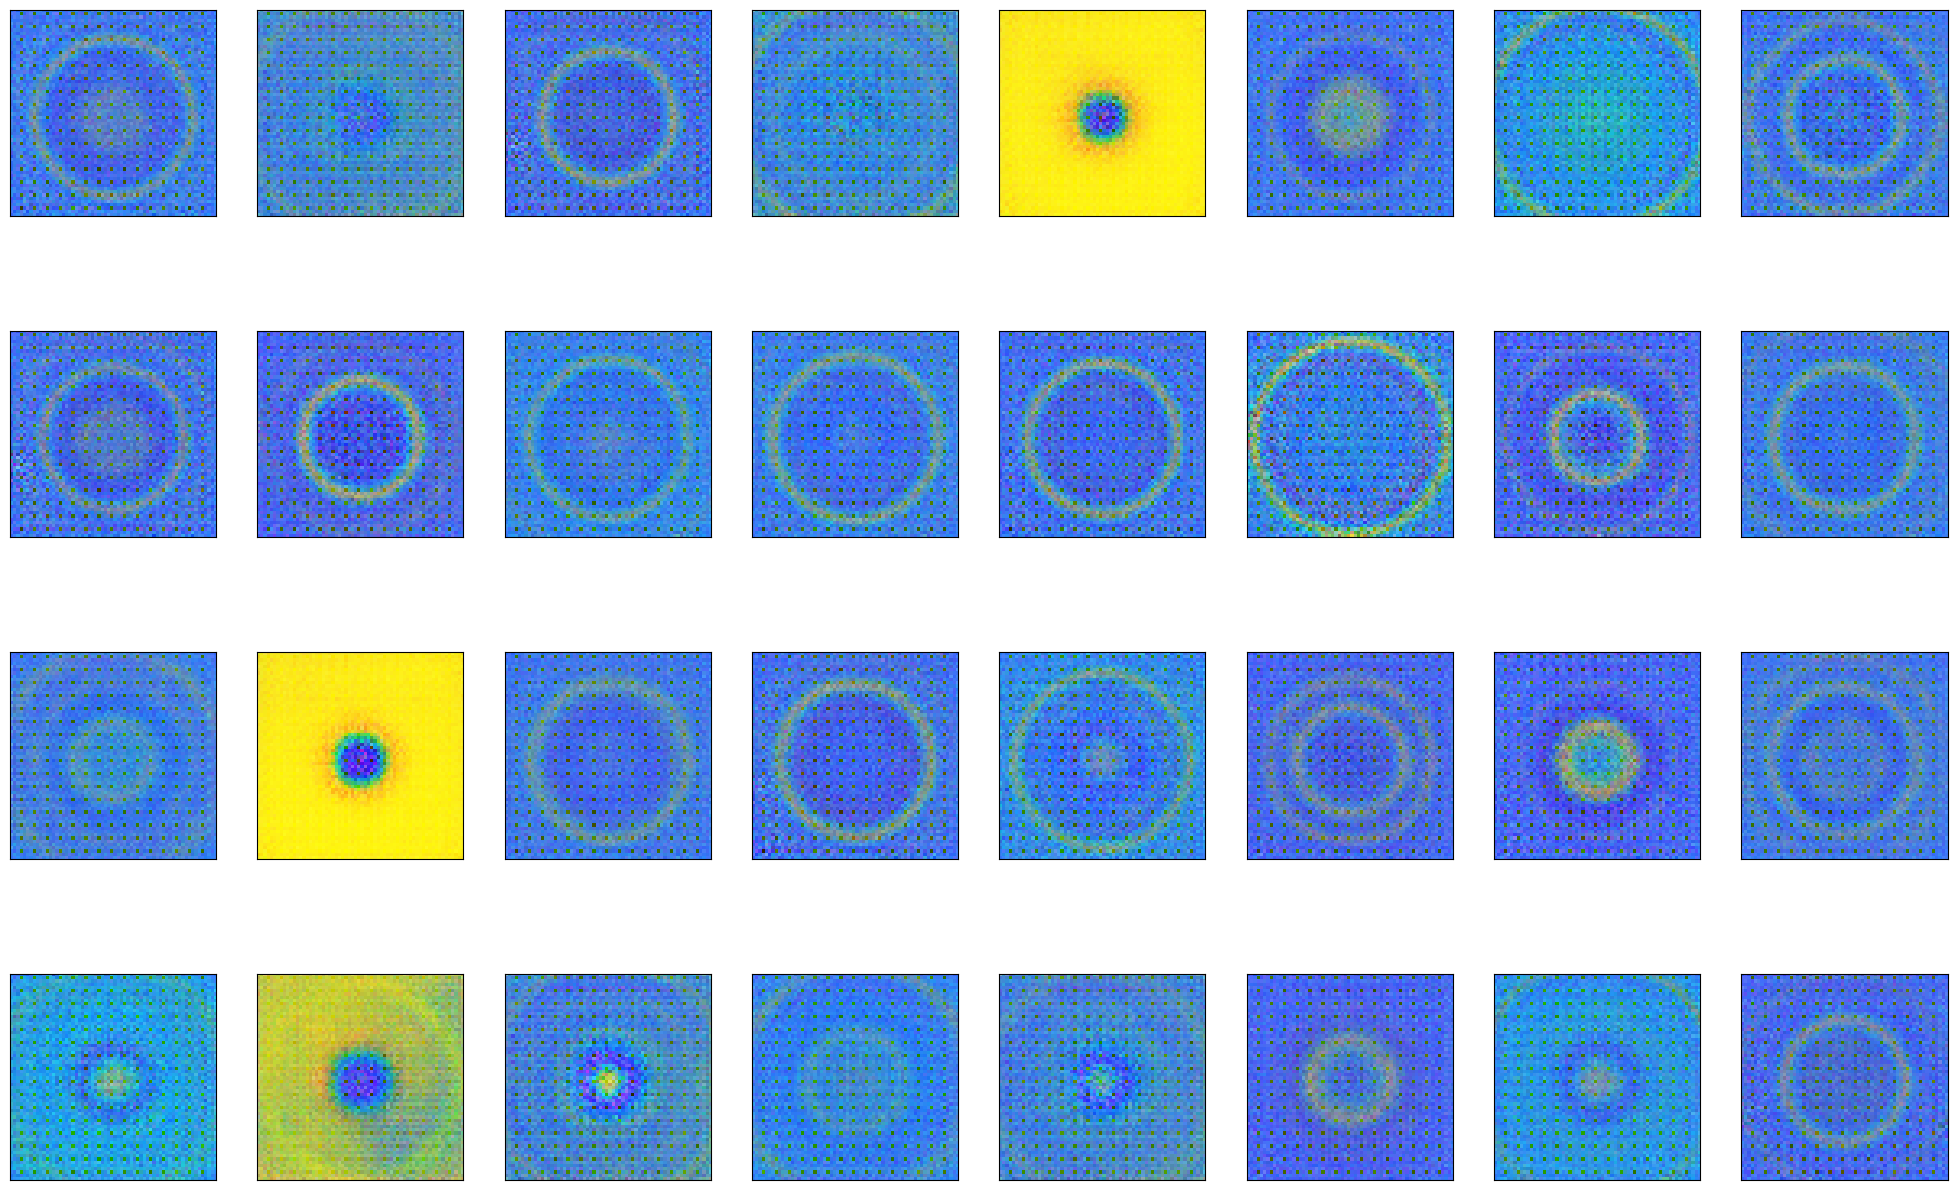

[202/1000][11/23] Loss_D: -79.0642 Loss_G: 68.0307
[202/1000][22/23] Loss_D: -70.6472 Loss_G: 68.9666
[203/1000][11/23] Loss_D: -71.8448 Loss_G: 74.1201
[203/1000][22/23] Loss_D: -81.7440 Loss_G: 75.8078
[204/1000][11/23] Loss_D: -91.5186 Loss_G: 69.9279
[204/1000][22/23] Loss_D: -67.8988 Loss_G: 70.9260
[205/1000][11/23] Loss_D: -80.7860 Loss_G: 73.3391
[205/1000][22/23] Loss_D: -88.3916 Loss_G: 76.2936
[206/1000][11/23] Loss_D: -84.9019 Loss_G: 71.5437
[206/1000][22/23] Loss_D: -65.7012 Loss_G: 70.9169
[207/1000][11/23] Loss_D: -69.9908 Loss_G: 71.8257
[207/1000][22/23] Loss_D: -79.8269 Loss_G: 69.8405
[208/1000][11/23] Loss_D: -79.8420 Loss_G: 73.0814
[208/1000][22/23] Loss_D: -79.3011 Loss_G: 75.8735
[209/1000][11/23] Loss_D: -75.1074 Loss_G: 74.9728
[209/1000][22/23] Loss_D: -76.4074 Loss_G: 71.2269
[210/1000][11/23] Loss_D: -77.9655 Loss_G: 72.2922
[210/1000][22/23] Loss_D: -73.5796 Loss_G: 73.8328
[211/1000][11/23] Loss_D: -82.5636 Loss_G: 75.5553
[211/1000][22/23] Loss_D: -75.4

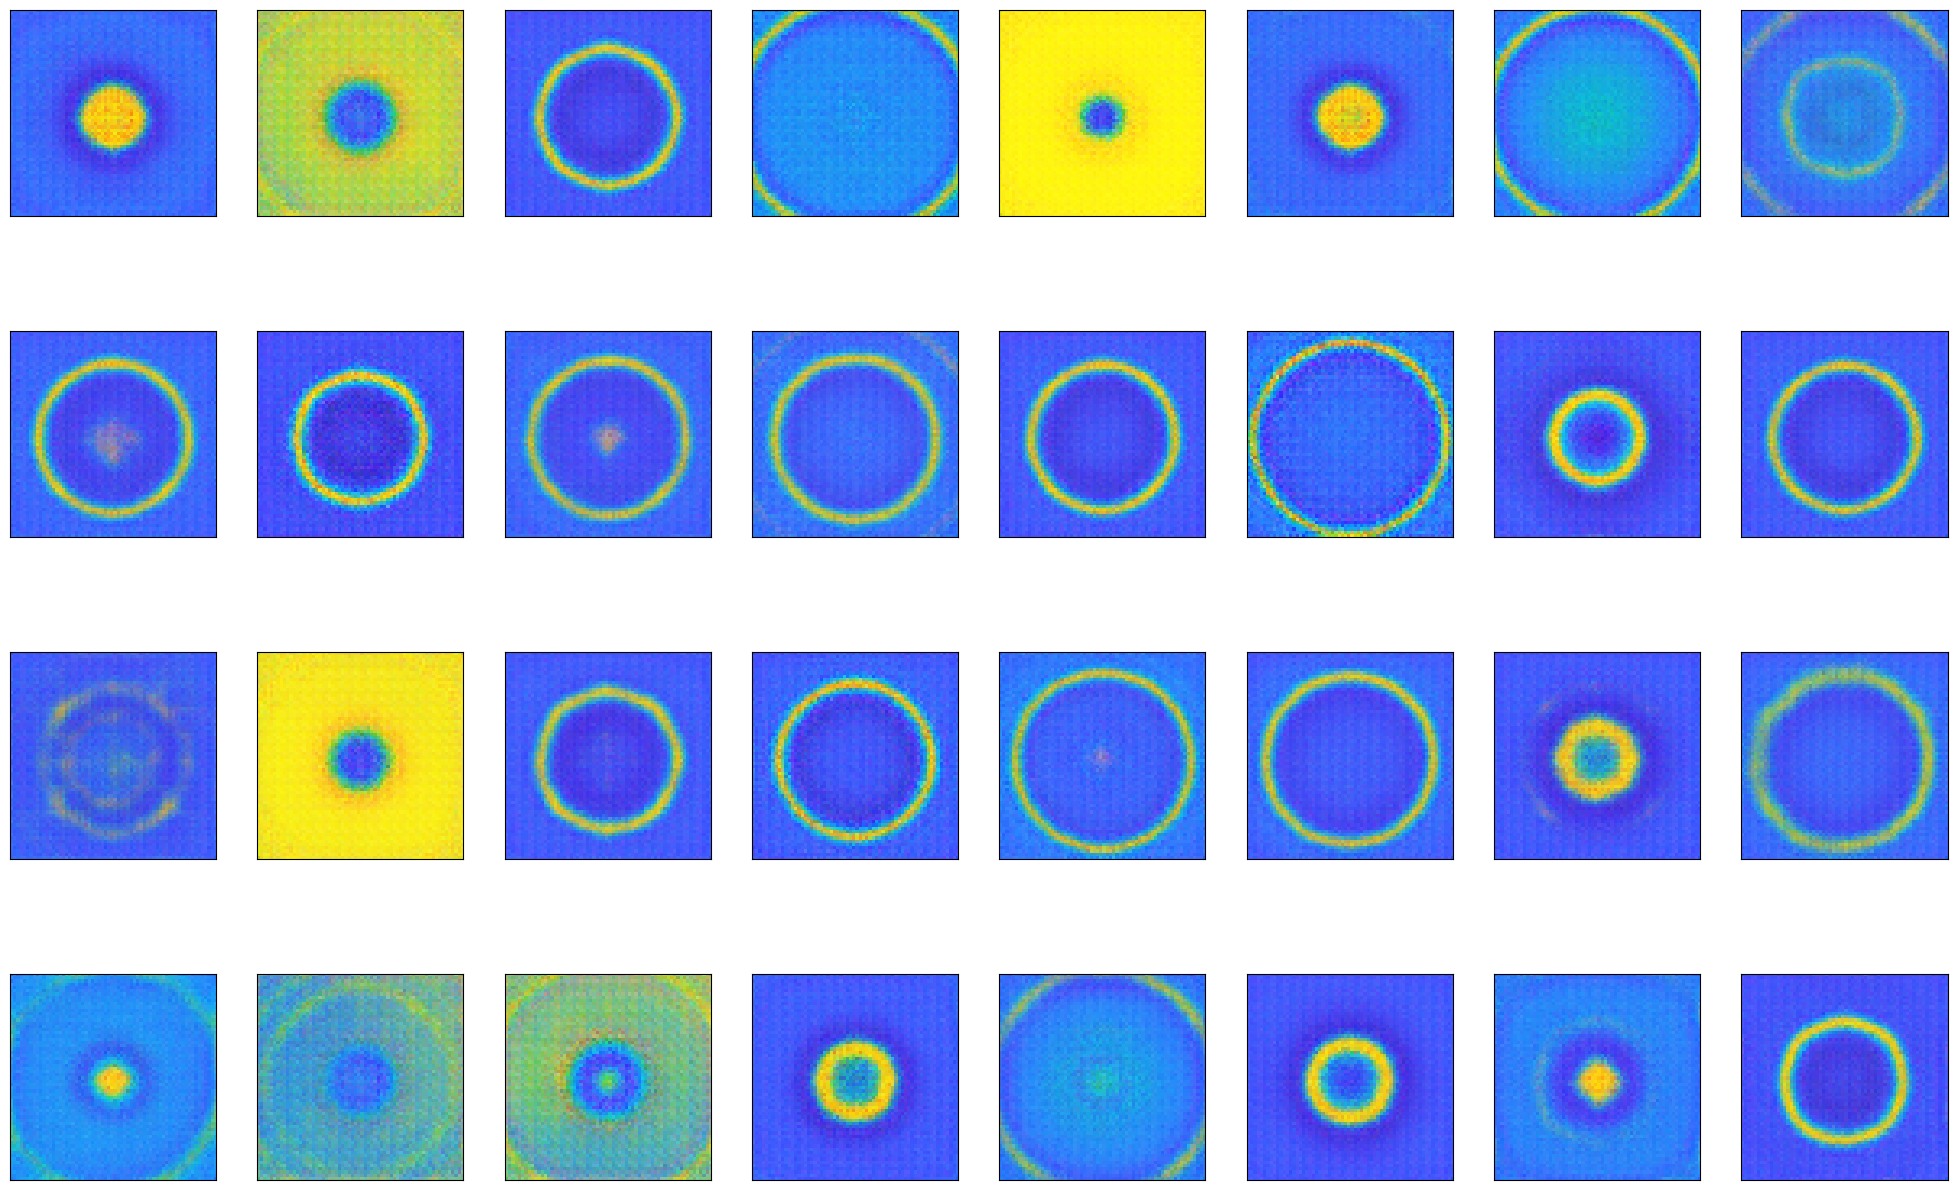

[302/1000][11/23] Loss_D: -5.8674 Loss_G: 41.5076
[302/1000][22/23] Loss_D: -10.5312 Loss_G: 46.2322
[303/1000][11/23] Loss_D: -9.8043 Loss_G: 46.8470
[303/1000][22/23] Loss_D: -5.3865 Loss_G: 45.1654
[304/1000][11/23] Loss_D: -7.6630 Loss_G: 44.3420
[304/1000][22/23] Loss_D: -14.9773 Loss_G: 43.9897
[305/1000][11/23] Loss_D: -15.2071 Loss_G: 51.2121
[305/1000][22/23] Loss_D: -11.6734 Loss_G: 45.0855
[306/1000][11/23] Loss_D: -16.8092 Loss_G: 48.7937
[306/1000][22/23] Loss_D: -6.8510 Loss_G: 39.5384
[307/1000][11/23] Loss_D: -15.2499 Loss_G: 50.2015
[307/1000][22/23] Loss_D: -14.6043 Loss_G: 48.8793
[308/1000][11/23] Loss_D: -3.9736 Loss_G: 40.7988
[308/1000][22/23] Loss_D: -13.3378 Loss_G: 44.4751
[309/1000][11/23] Loss_D: -10.7250 Loss_G: 39.3093
[309/1000][22/23] Loss_D: -7.1900 Loss_G: 30.2049
[310/1000][11/23] Loss_D: -11.8089 Loss_G: 37.6019
[310/1000][22/23] Loss_D: -12.1609 Loss_G: 44.5468
[311/1000][11/23] Loss_D: -19.1415 Loss_G: 47.6962
[311/1000][22/23] Loss_D: -18.0523 Los

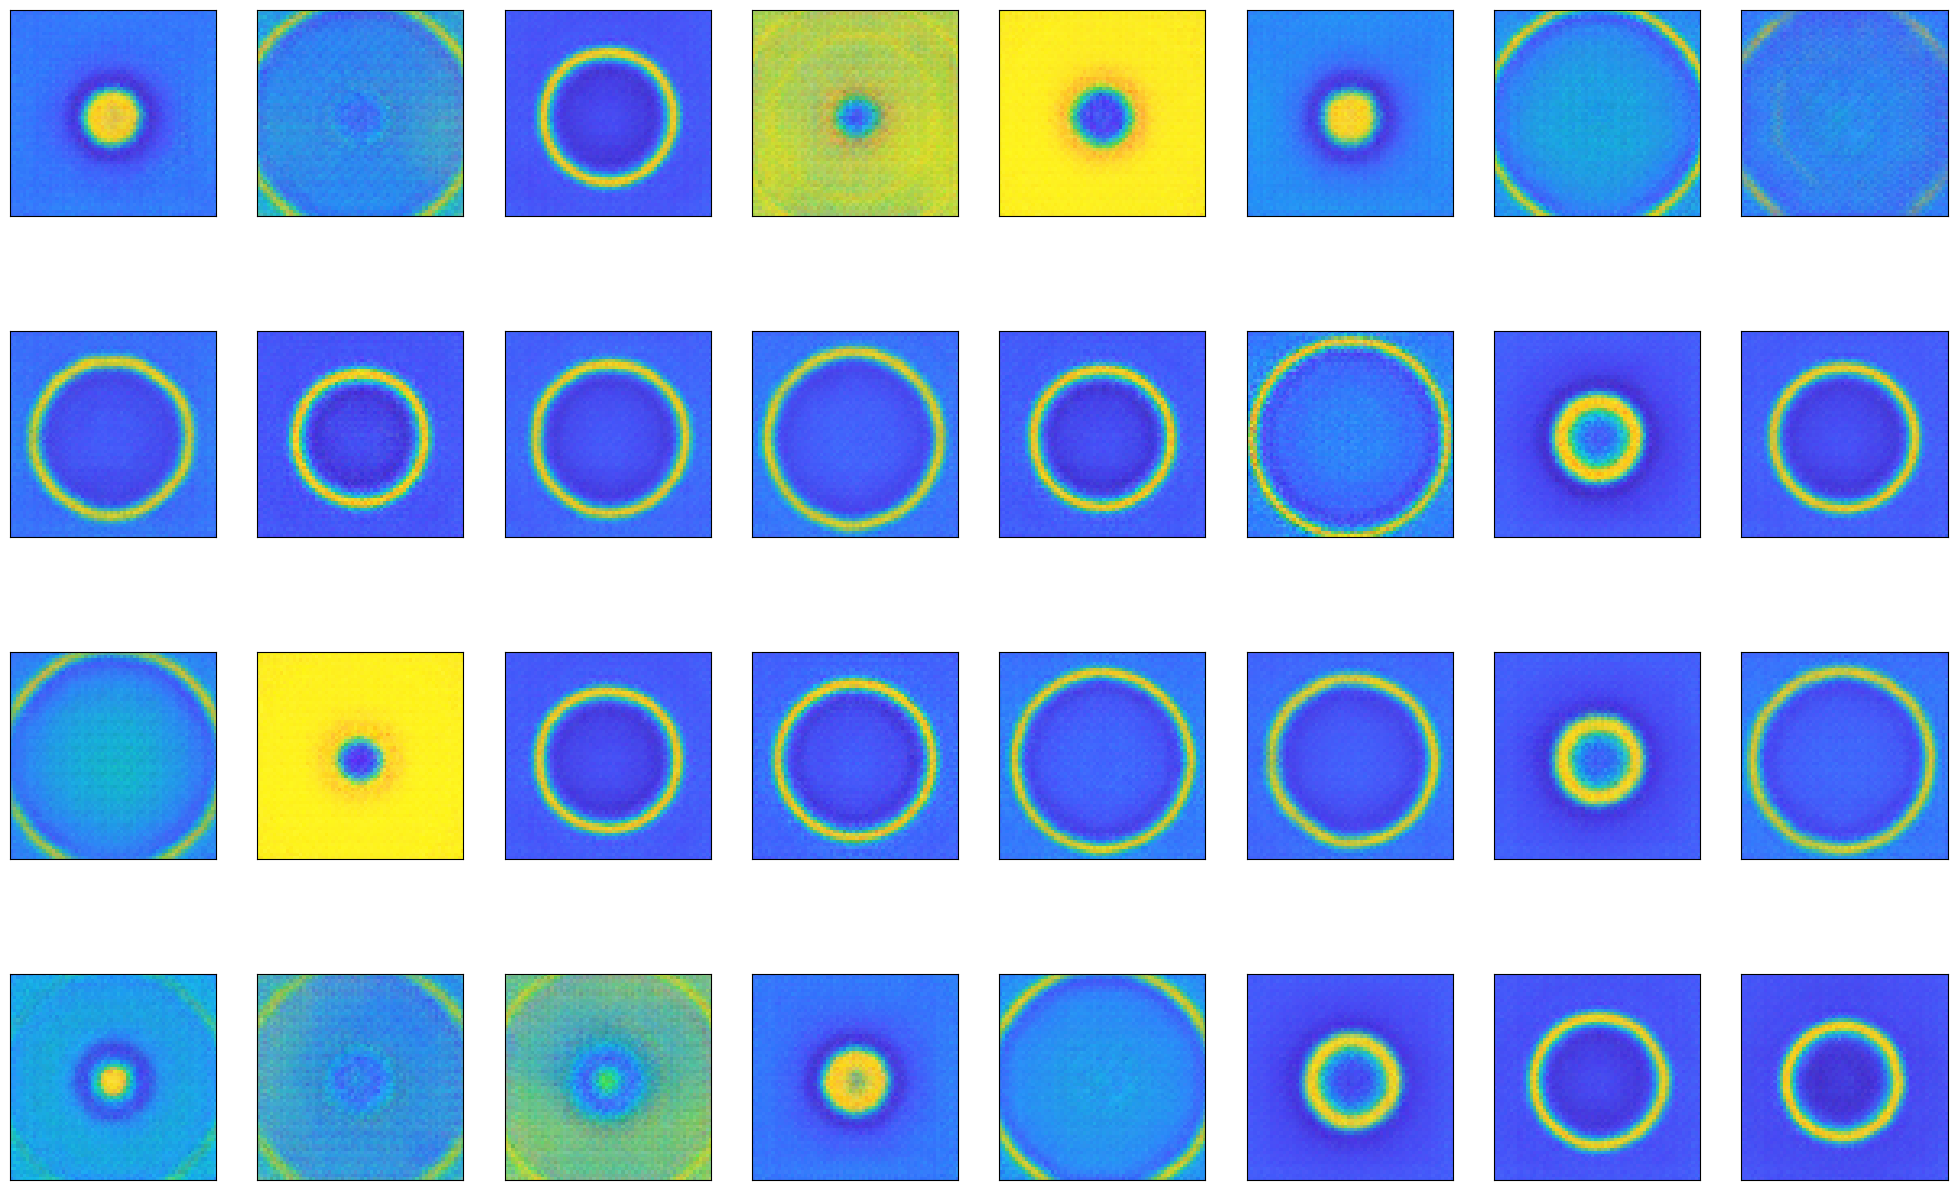

[402/1000][11/23] Loss_D: -15.1591 Loss_G: 32.6100
[402/1000][22/23] Loss_D: -9.9660 Loss_G: 32.5167
[403/1000][11/23] Loss_D: -8.2404 Loss_G: 29.8741
[403/1000][22/23] Loss_D: -11.2097 Loss_G: 34.7768
[404/1000][11/23] Loss_D: -8.7515 Loss_G: 27.8336
[404/1000][22/23] Loss_D: -5.8309 Loss_G: 32.1781
[405/1000][11/23] Loss_D: -8.4506 Loss_G: 34.0129
[405/1000][22/23] Loss_D: -12.5081 Loss_G: 34.7354
[406/1000][11/23] Loss_D: -5.5326 Loss_G: 29.9462
[406/1000][22/23] Loss_D: -11.2519 Loss_G: 44.6419
[407/1000][11/23] Loss_D: -13.0323 Loss_G: 33.1135
[407/1000][22/23] Loss_D: -6.7727 Loss_G: 32.2252
[408/1000][11/23] Loss_D: -19.1270 Loss_G: 42.1318
[408/1000][22/23] Loss_D: -11.9490 Loss_G: 30.8034
[409/1000][11/23] Loss_D: -0.0481 Loss_G: 31.9242
[409/1000][22/23] Loss_D: -2.9665 Loss_G: 26.5226
[410/1000][11/23] Loss_D: -8.0515 Loss_G: 30.7757
[410/1000][22/23] Loss_D: -5.0220 Loss_G: 27.4669
[411/1000][11/23] Loss_D: -7.2344 Loss_G: 31.6832
[411/1000][22/23] Loss_D: -7.6034 Loss_G: 3

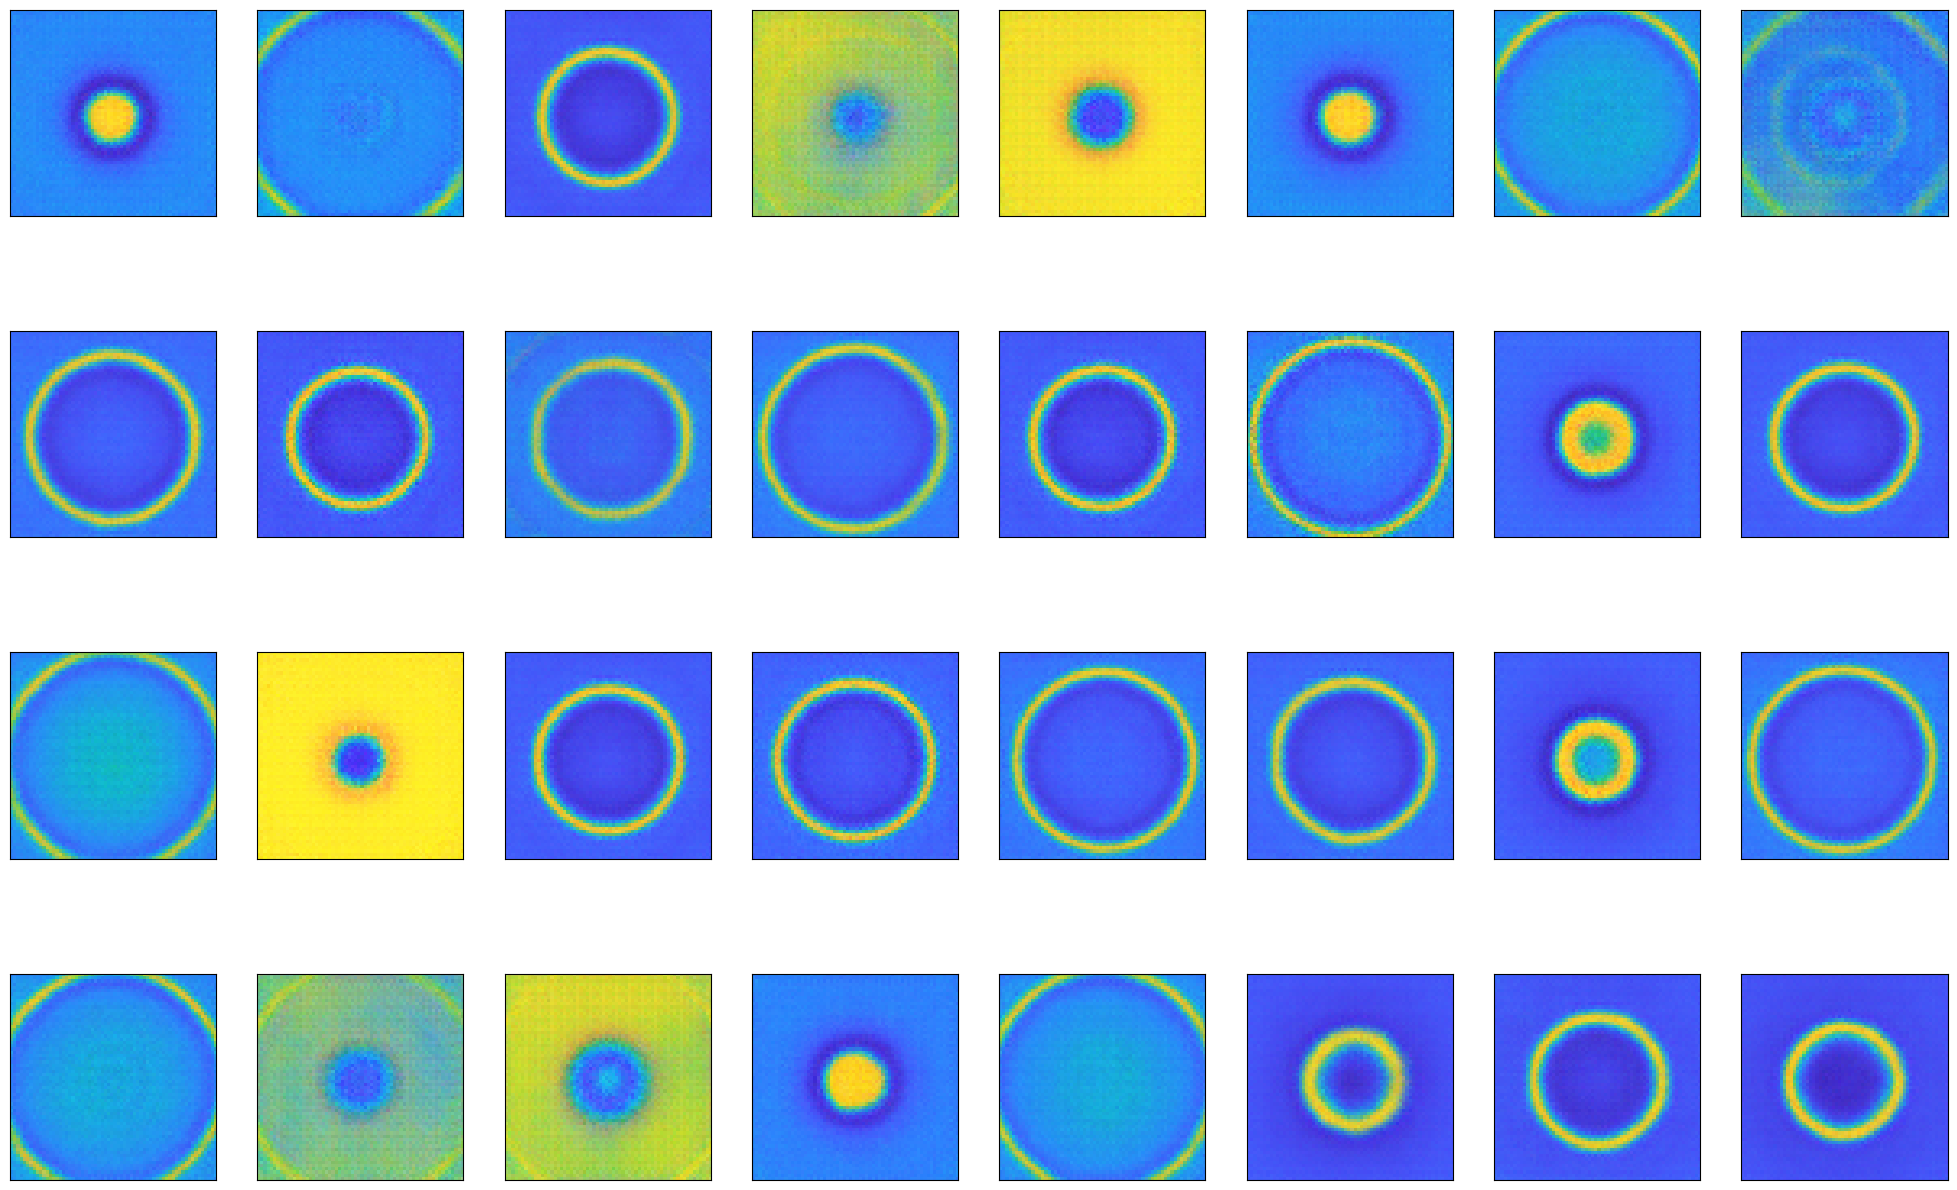

[502/1000][11/23] Loss_D: -4.7275 Loss_G: 17.0667
[502/1000][22/23] Loss_D: -4.6816 Loss_G: 20.3278
[503/1000][11/23] Loss_D: -21.4590 Loss_G: 42.2110
[503/1000][22/23] Loss_D: -7.0843 Loss_G: 18.9621
[504/1000][11/23] Loss_D: -5.6067 Loss_G: 16.9714
[504/1000][22/23] Loss_D: -6.3455 Loss_G: 19.1730
[505/1000][11/23] Loss_D: -5.2421 Loss_G: 23.5567
[505/1000][22/23] Loss_D: -8.1085 Loss_G: 18.6083
[506/1000][11/23] Loss_D: -7.8549 Loss_G: 23.7529
[506/1000][22/23] Loss_D: -15.3102 Loss_G: 24.7224
[507/1000][11/23] Loss_D: -7.3365 Loss_G: 11.2680
[507/1000][22/23] Loss_D: -6.0382 Loss_G: 14.5035
[508/1000][11/23] Loss_D: -6.2945 Loss_G: 16.4595
[508/1000][22/23] Loss_D: -10.5100 Loss_G: 21.9690
[509/1000][11/23] Loss_D: -13.0730 Loss_G: 21.7058
[509/1000][22/23] Loss_D: -9.0640 Loss_G: 21.6058
[510/1000][11/23] Loss_D: -6.7618 Loss_G: 21.1376
[510/1000][22/23] Loss_D: -8.4374 Loss_G: 20.2805
[511/1000][11/23] Loss_D: -8.6038 Loss_G: 17.8677
[511/1000][22/23] Loss_D: -4.5074 Loss_G: 12.3

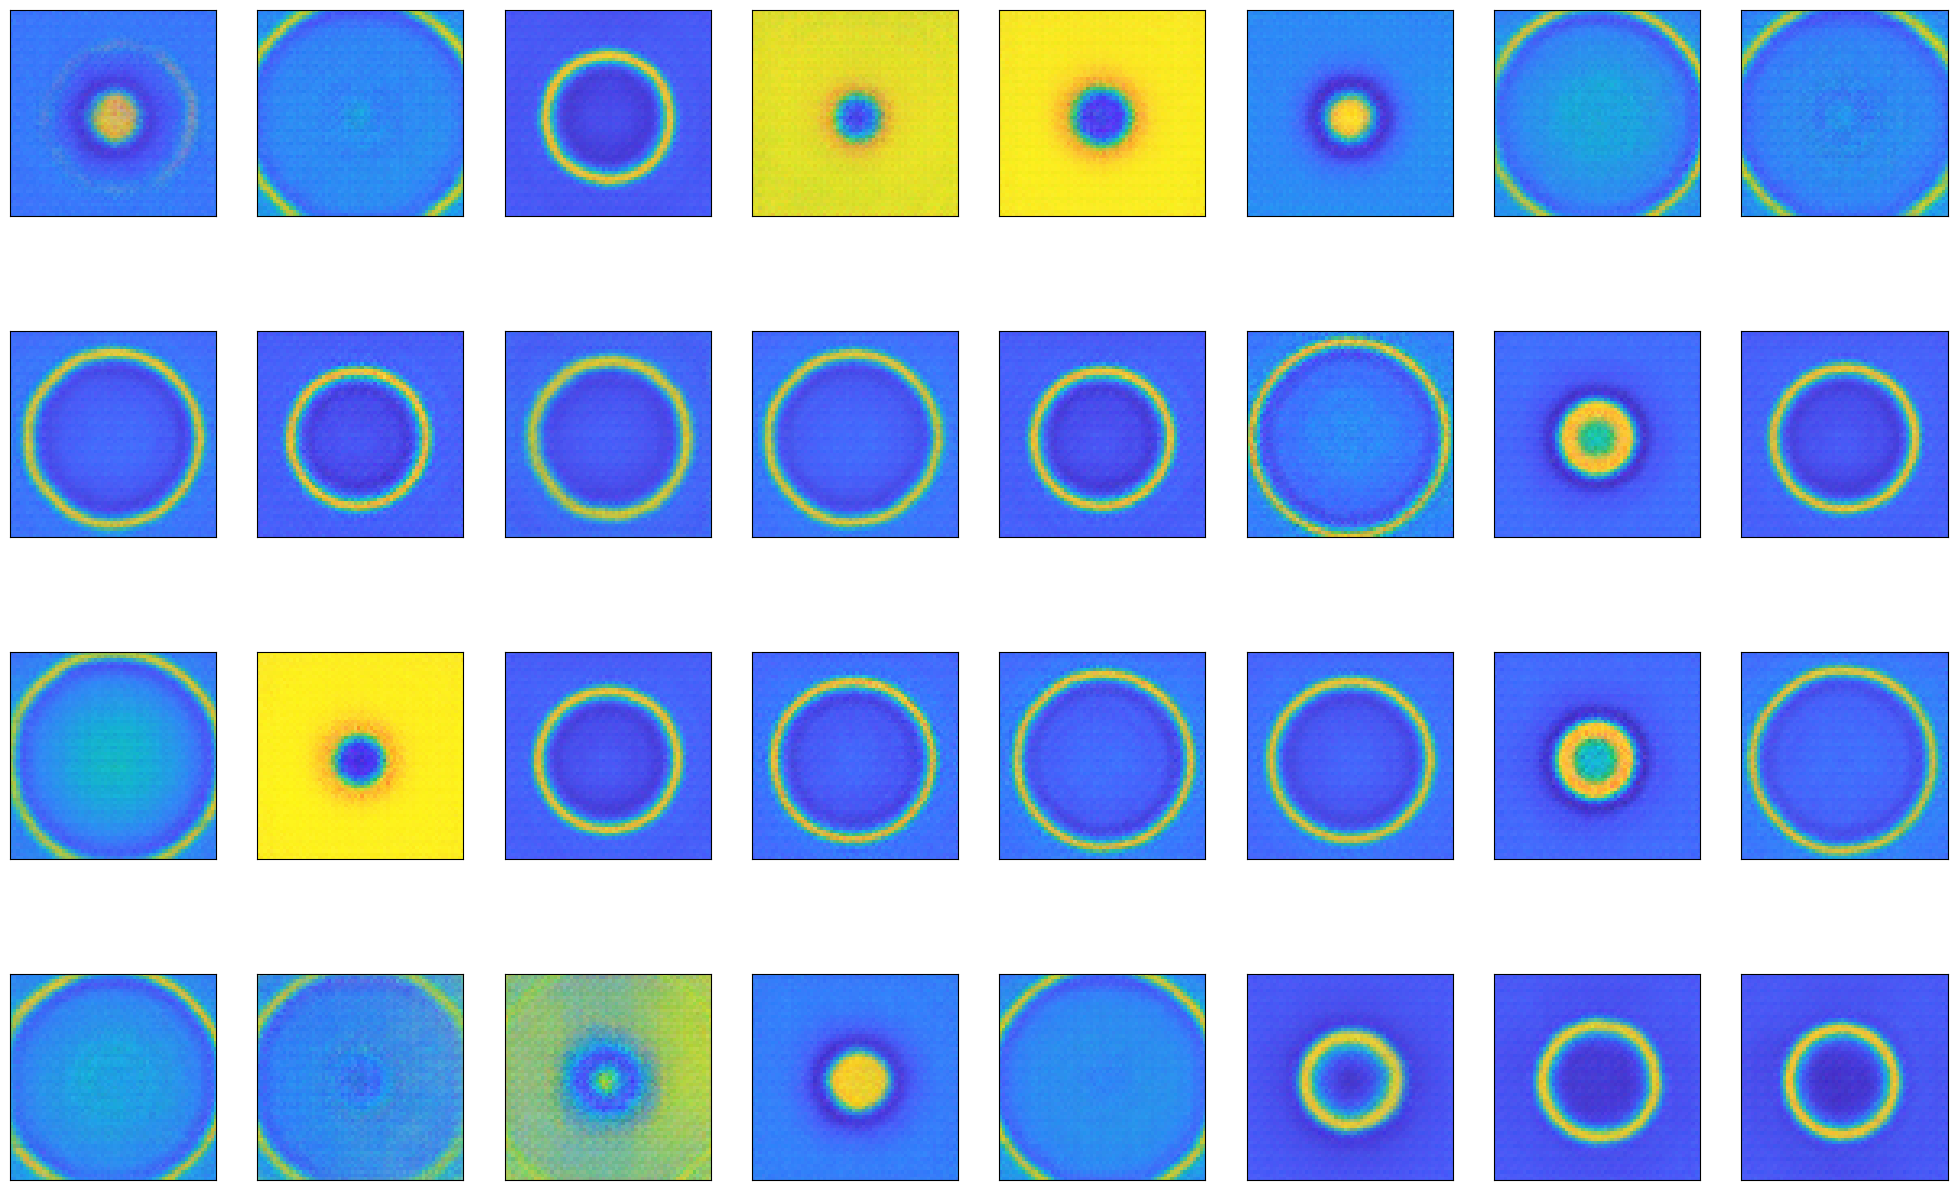

[602/1000][11/23] Loss_D: -11.0488 Loss_G: 19.4109
[602/1000][22/23] Loss_D: -6.0507 Loss_G: 15.5594
[603/1000][11/23] Loss_D: -8.4989 Loss_G: 11.0782
[603/1000][22/23] Loss_D: -6.4318 Loss_G: 12.7140
[604/1000][11/23] Loss_D: -12.2833 Loss_G: 24.3396
[604/1000][22/23] Loss_D: -8.2632 Loss_G: 16.0085
[605/1000][11/23] Loss_D: -5.2038 Loss_G: 12.8709
[605/1000][22/23] Loss_D: -5.4052 Loss_G: 15.0848
[606/1000][11/23] Loss_D: -6.5063 Loss_G: 15.5296
[606/1000][22/23] Loss_D: -8.3482 Loss_G: 16.9628
[607/1000][11/23] Loss_D: -7.0769 Loss_G: 14.6262
[607/1000][22/23] Loss_D: -2.1057 Loss_G: 4.9318
[608/1000][11/23] Loss_D: -10.1565 Loss_G: 20.5958
[608/1000][22/23] Loss_D: -7.8615 Loss_G: 12.9593
[609/1000][11/23] Loss_D: -8.2644 Loss_G: 18.6662
[609/1000][22/23] Loss_D: -2.5042 Loss_G: 11.4589
[610/1000][11/23] Loss_D: -7.1557 Loss_G: 13.3372
[610/1000][22/23] Loss_D: -6.8979 Loss_G: 12.2332
[611/1000][11/23] Loss_D: -15.1858 Loss_G: 17.1381
[611/1000][22/23] Loss_D: -8.2088 Loss_G: 15.13

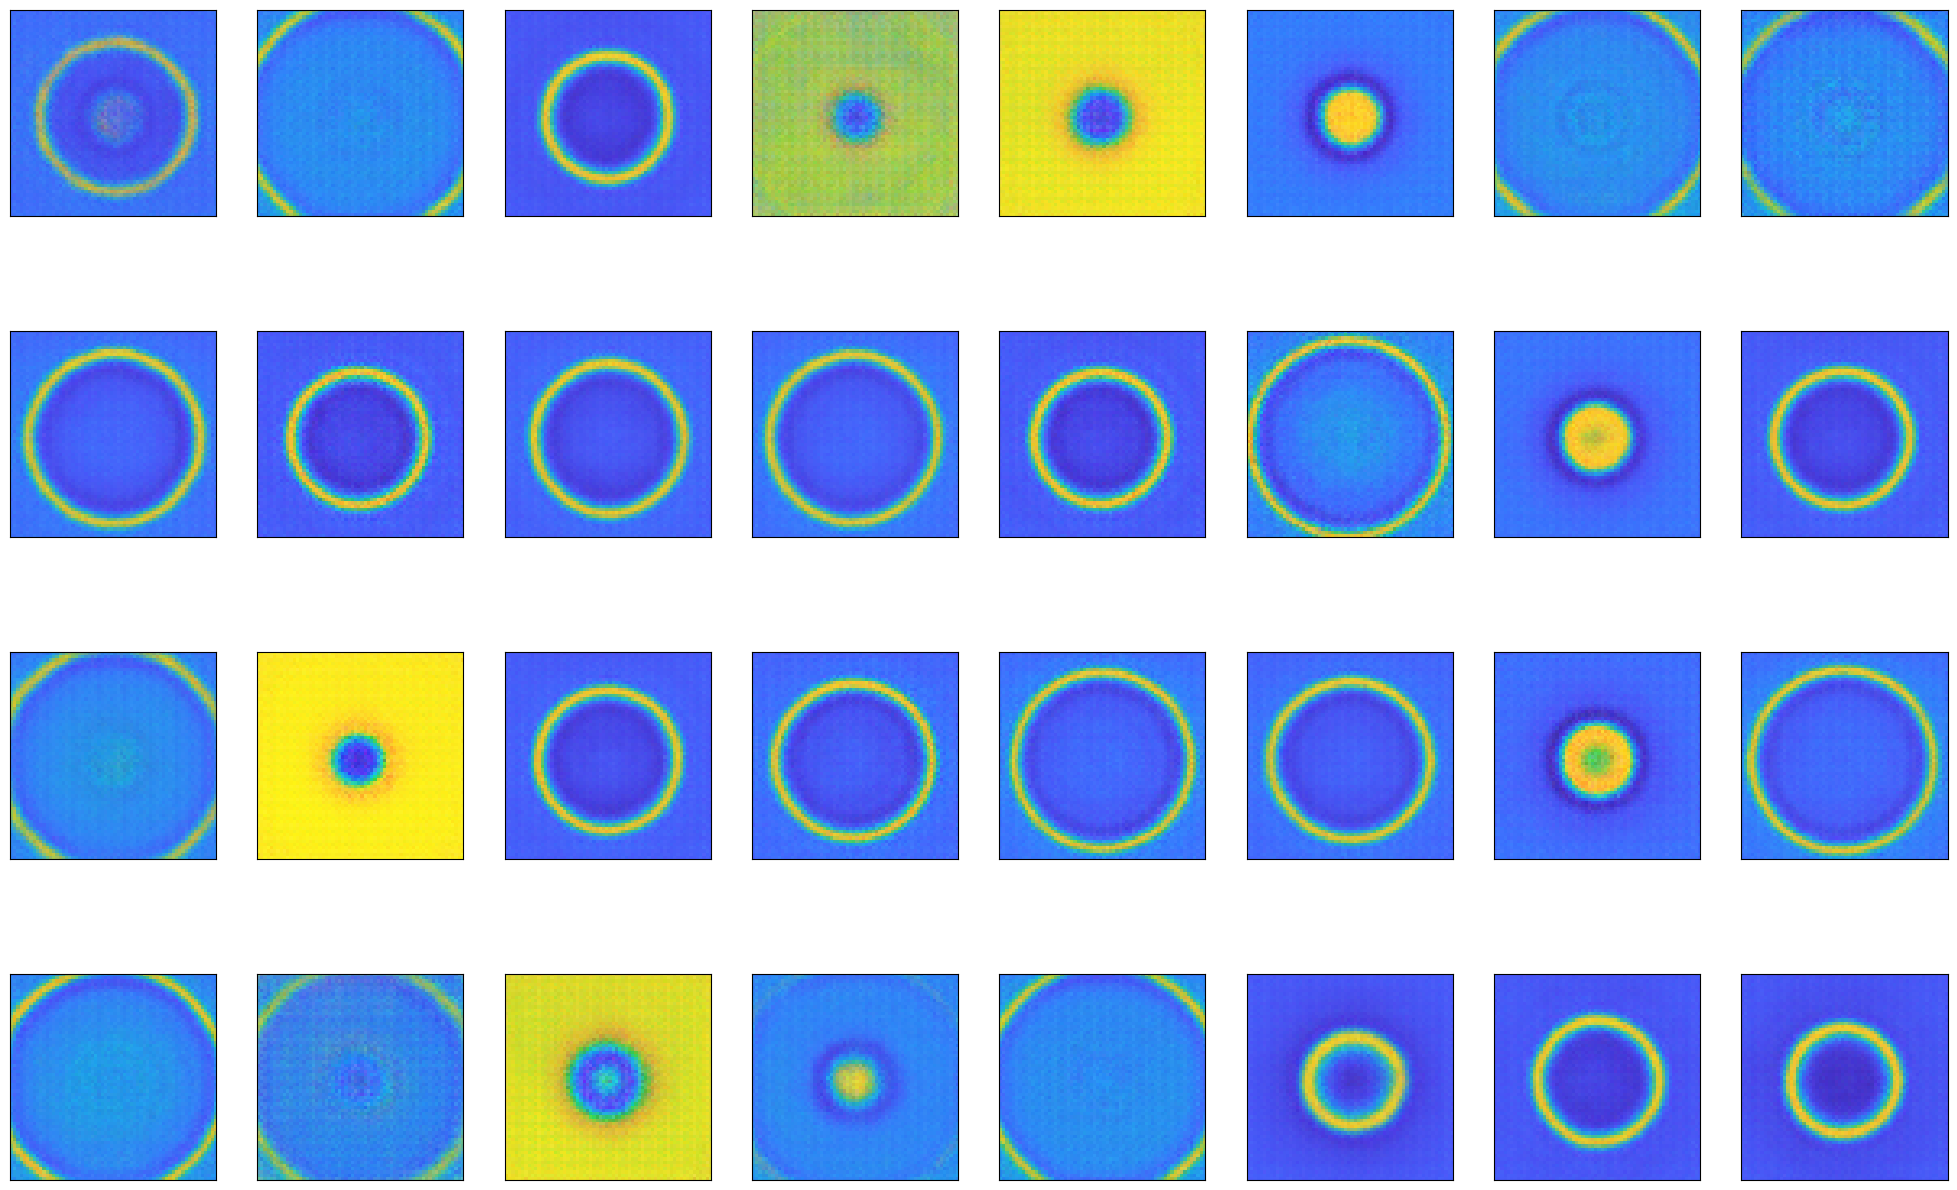

[702/1000][11/23] Loss_D: -7.3188 Loss_G: 14.3839
[702/1000][22/23] Loss_D: -6.7206 Loss_G: 11.4897
[703/1000][11/23] Loss_D: -6.2438 Loss_G: 9.0451
[703/1000][22/23] Loss_D: -7.6411 Loss_G: 11.0293
[704/1000][11/23] Loss_D: -8.7633 Loss_G: 15.8138
[704/1000][22/23] Loss_D: -8.8314 Loss_G: 15.2169
[705/1000][11/23] Loss_D: -5.0428 Loss_G: 10.9977
[705/1000][22/23] Loss_D: -6.1567 Loss_G: 10.8967
[706/1000][11/23] Loss_D: -12.1129 Loss_G: 17.4574
[706/1000][22/23] Loss_D: -5.1148 Loss_G: 9.5153
[707/1000][11/23] Loss_D: -4.8559 Loss_G: 12.4660
[707/1000][22/23] Loss_D: -7.0809 Loss_G: 8.3734
[708/1000][11/23] Loss_D: -4.9770 Loss_G: 8.7180
[708/1000][22/23] Loss_D: -2.9045 Loss_G: 9.6094
[709/1000][11/23] Loss_D: -12.1487 Loss_G: 19.1022
[709/1000][22/23] Loss_D: -4.5625 Loss_G: 10.1416
[710/1000][11/23] Loss_D: -9.9609 Loss_G: 16.1134
[710/1000][22/23] Loss_D: -6.2153 Loss_G: 14.8258
[711/1000][11/23] Loss_D: -19.1691 Loss_G: 29.3809
[711/1000][22/23] Loss_D: -12.9868 Loss_G: 12.7022
[

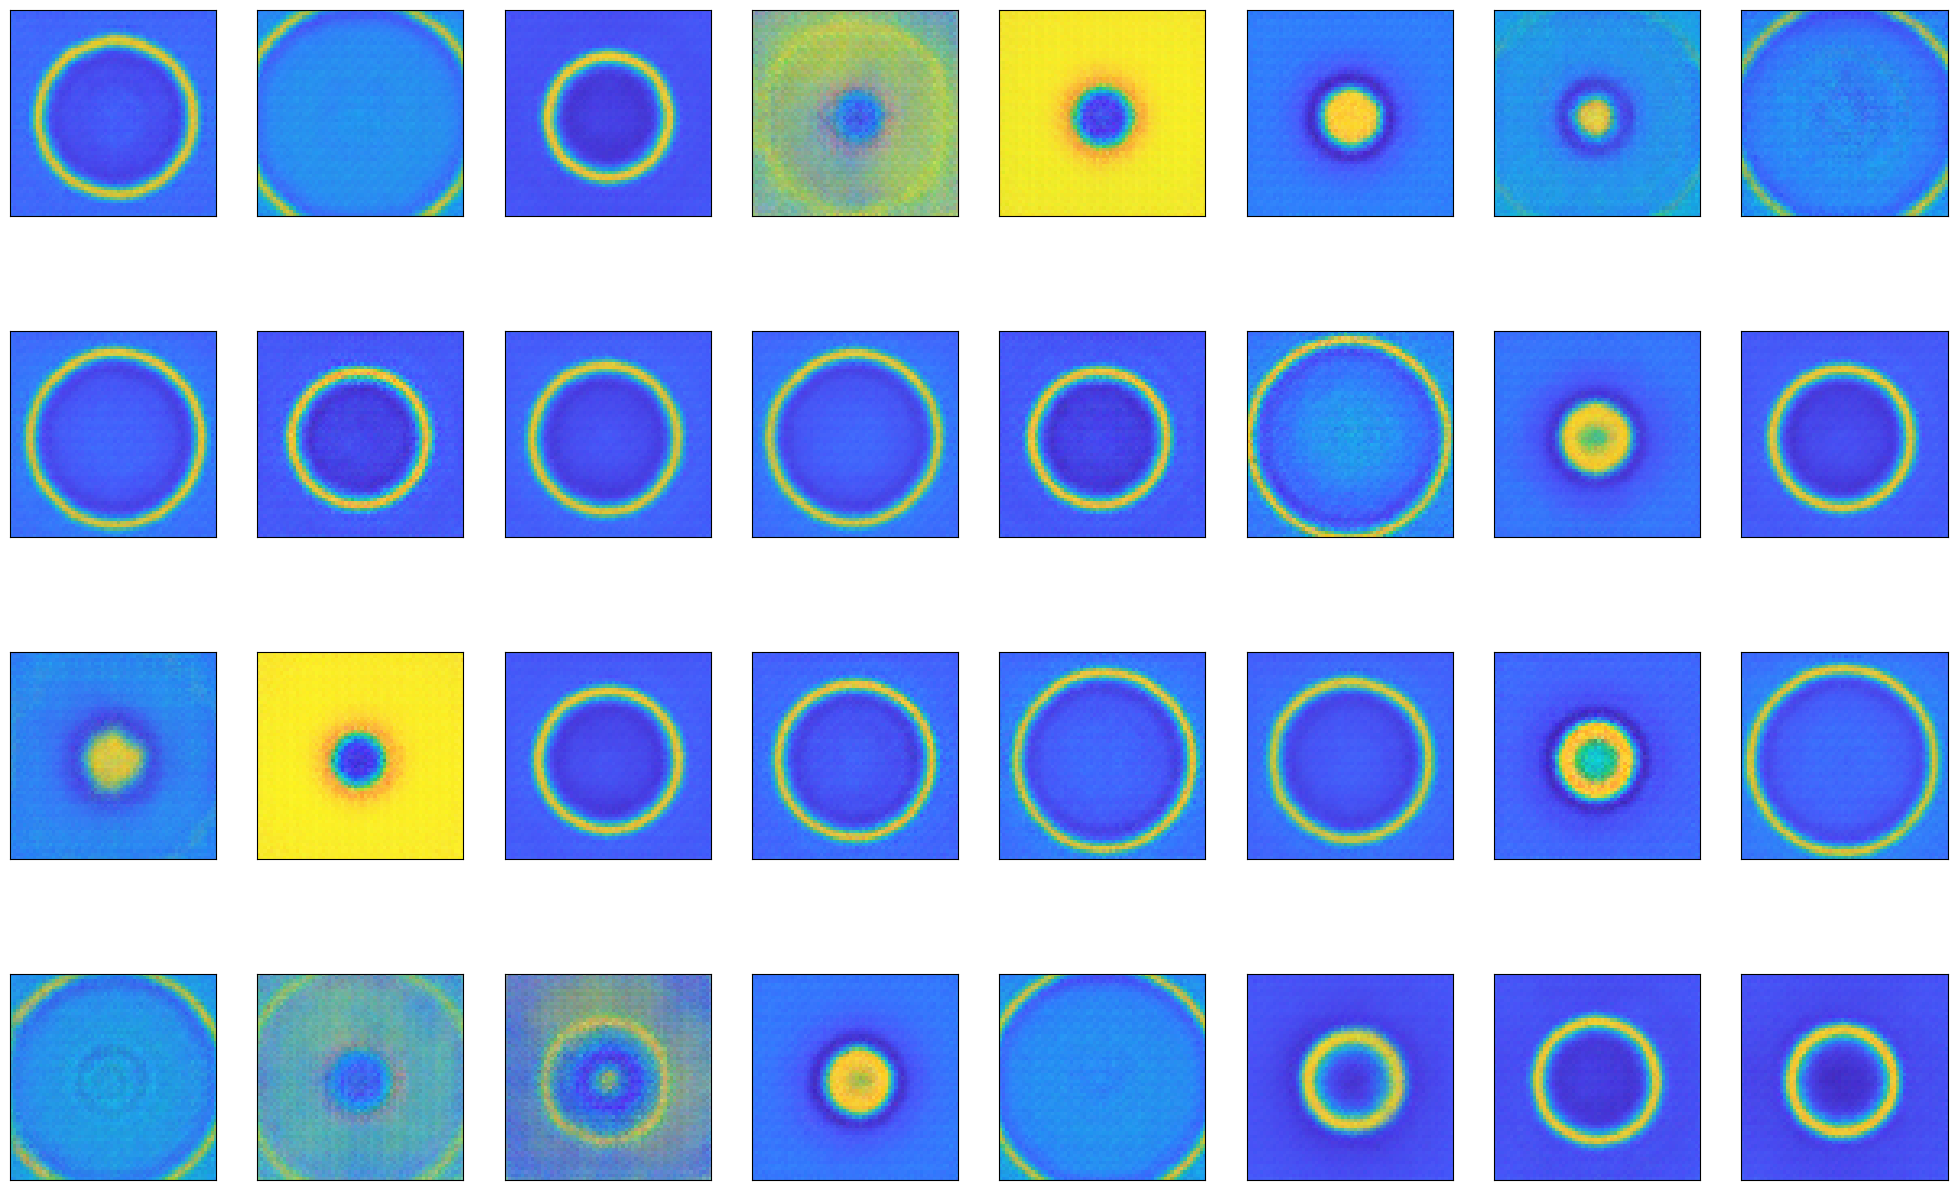

[802/1000][11/23] Loss_D: -10.2825 Loss_G: 14.8976
[802/1000][22/23] Loss_D: -15.1348 Loss_G: 17.4527
[803/1000][11/23] Loss_D: -10.7089 Loss_G: 14.0233
[803/1000][22/23] Loss_D: -9.4722 Loss_G: 8.3971
[804/1000][11/23] Loss_D: -14.8363 Loss_G: 18.9690
[804/1000][22/23] Loss_D: -3.5186 Loss_G: 12.9251
[805/1000][11/23] Loss_D: -3.9721 Loss_G: 8.1357
[805/1000][22/23] Loss_D: -4.0388 Loss_G: 10.5912
[806/1000][11/23] Loss_D: -5.8188 Loss_G: 15.4946
[806/1000][22/23] Loss_D: -8.0787 Loss_G: 11.0001
[807/1000][11/23] Loss_D: -4.3224 Loss_G: 11.8087
[807/1000][22/23] Loss_D: -8.9080 Loss_G: 11.7794
[808/1000][11/23] Loss_D: -8.5213 Loss_G: 13.5777
[808/1000][22/23] Loss_D: -1.0060 Loss_G: 11.8044
[809/1000][11/23] Loss_D: -21.5359 Loss_G: 29.4460
[809/1000][22/23] Loss_D: -7.0336 Loss_G: 11.2718
[810/1000][11/23] Loss_D: -17.6866 Loss_G: 21.0974
[810/1000][22/23] Loss_D: -8.6703 Loss_G: 13.3630
[811/1000][11/23] Loss_D: -5.3689 Loss_G: 16.4862
[811/1000][22/23] Loss_D: -6.4683 Loss_G: 6.56

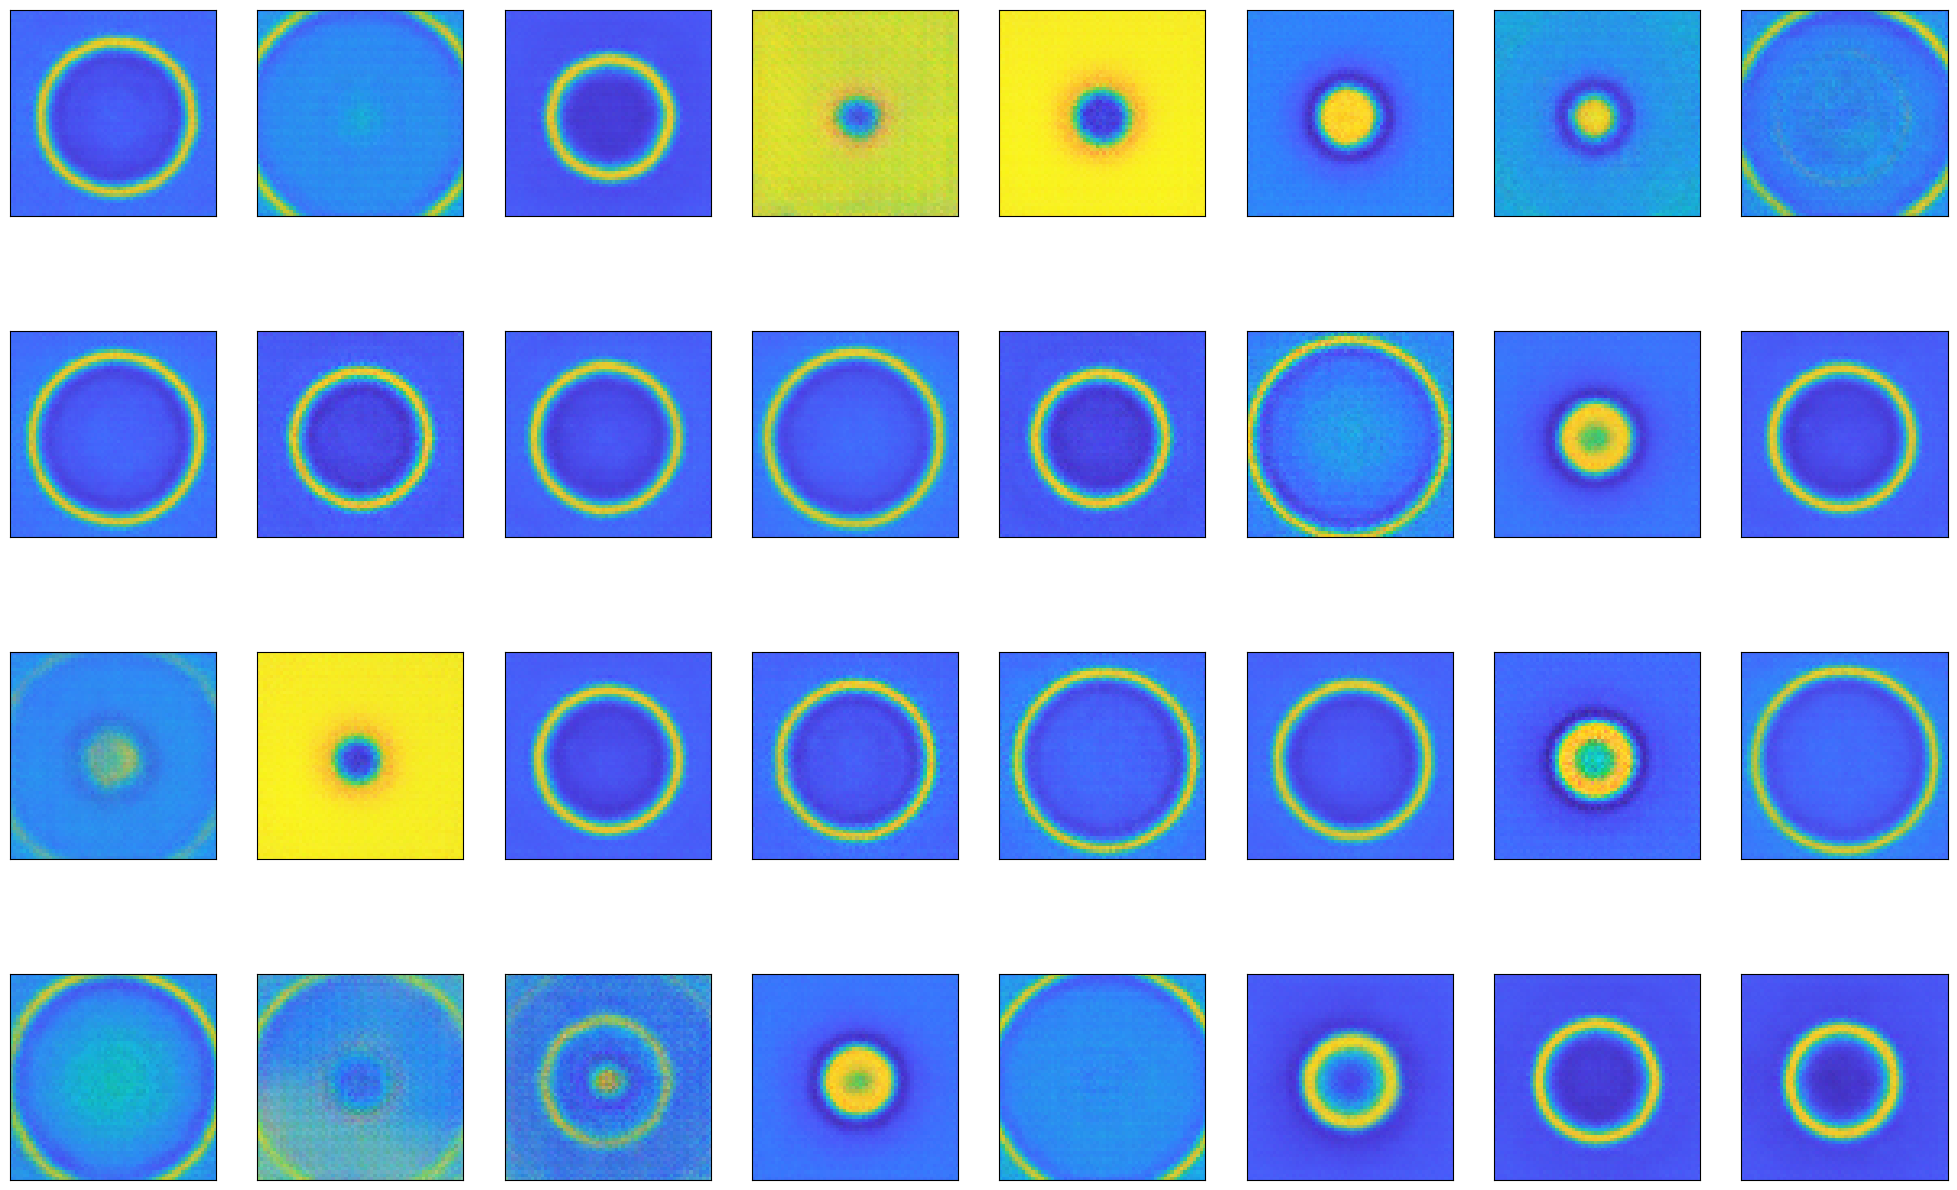

[902/1000][11/23] Loss_D: -5.8505 Loss_G: 6.8746
[902/1000][22/23] Loss_D: -2.8101 Loss_G: 2.6372
[903/1000][11/23] Loss_D: -5.2132 Loss_G: 8.5147
[903/1000][22/23] Loss_D: -3.1704 Loss_G: 5.6577
[904/1000][11/23] Loss_D: -10.7596 Loss_G: 11.0117
[904/1000][22/23] Loss_D: -7.4919 Loss_G: 5.4798
[905/1000][11/23] Loss_D: -5.8553 Loss_G: 6.3803
[905/1000][22/23] Loss_D: -3.1110 Loss_G: 5.2079
[906/1000][11/23] Loss_D: -9.0054 Loss_G: 8.2495
[906/1000][22/23] Loss_D: -2.7956 Loss_G: 2.0447
[907/1000][11/23] Loss_D: -1.1014 Loss_G: 1.7007
[907/1000][22/23] Loss_D: -9.6878 Loss_G: 9.3299
[908/1000][11/23] Loss_D: -5.4675 Loss_G: 8.4308
[908/1000][22/23] Loss_D: -11.9327 Loss_G: 12.3610
[909/1000][11/23] Loss_D: -6.7863 Loss_G: 11.2418
[909/1000][22/23] Loss_D: -6.0384 Loss_G: 6.8022
[910/1000][11/23] Loss_D: -6.8831 Loss_G: 6.3588
[910/1000][22/23] Loss_D: -4.4723 Loss_G: 9.9654
[911/1000][11/23] Loss_D: -1.4735 Loss_G: 7.1376
[911/1000][22/23] Loss_D: -8.9617 Loss_G: 9.5813
[912/1000][11/2

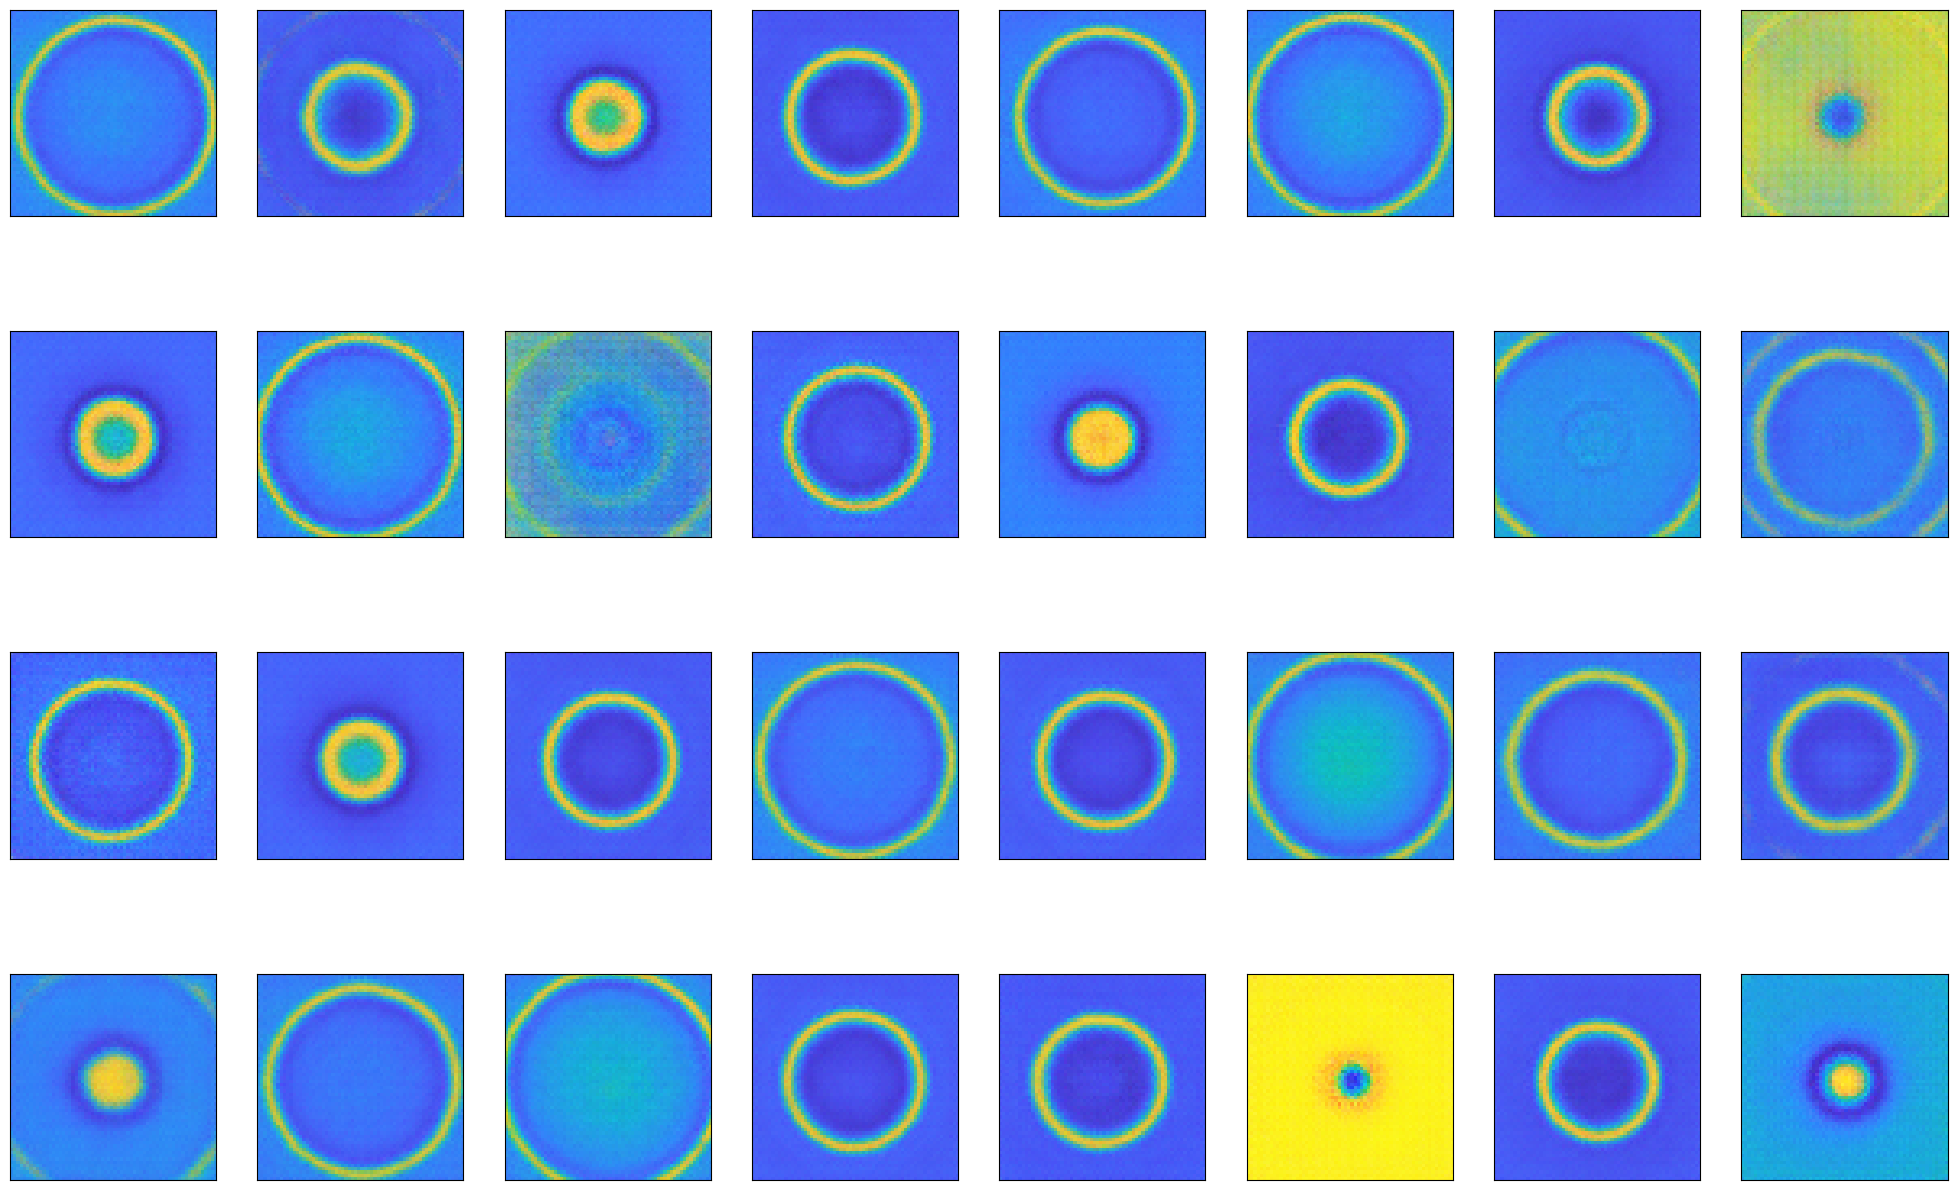

**********

 Saving Images with lr = 0.0001, batch_size=13, epochs=1000, nz=30, lambda_gp = 10, critic_size = 2
**********


In [10]:
import torch
# Iterate through combinations of parameters
for lambda_gp in lambda_gp_sizes:
    for num_disc_gen in num_disc_gen_sizes:
        for lr in lr_sizes:
            for batch_size in batch_sizes:
                for epochs in epochs_values:
                    for nz in nz_values:
                        # Training parameters
                        print(f"\nTraining with lr = {lr}, batch_size={batch_size}, epochs={epochs}, nz={nz}, lambda_gp = {lambda_gp}, critic_size = {num_disc_gen}")
                        beta1 = 0

                        # Labeling for discriminator
                        real_label = 0.5
                        fake_label = 0

                        # Setting up the device for training
                        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  

                        # Run your training and evaluation code
                        trainData(batch_size, nz, epochs, lr, lambda_gp, num_disc_gen)

#             # Check if current configuration is better than the previous best
#             if accuracy > best_accuracy:
#                 best_accuracy = accuracy
#                 best_parameters = {'batch_size': batch_size, 'epochs': epochs, 'nz': nz}

# Print the best configuration
# print(f"\nBest Configuration: {best_parameters}, Best Accuracy: {best_accuracy}")
